In [1]:

from statsmodels.regression.rolling import RollingOLS
#from alpha_vantage.timeseries import TimeSeries
#from nsepython import *
import time
import pandas_datareader.data as web
import matplotlib.pyplot as plt #plotting graphs from data
import statsmodels.api as sm
import pandas as pd #extracting and manipulating dataframes
import numpy as np #for using mathematical functions
import datetime as dt #used to convert string to datetime and creating time offset
import yfinance as yf #extracting data fields related to given stocks
import pandas_ta #calculating technical indicators
import warnings
warnings.filterwarnings('ignore')


In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()

In [6]:
end_date = dt.date.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)

In [7]:
df = yf.download(tickers=symbols_list, start=start_date, end=end_date, auto_adjust=False).stack()

[*********************100%***********************]  504 of 504 completed


In [8]:
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-05-18 A        39.272610   42.630001   42.700001   41.980000   42.049999   
           AAPL     29.196476   32.547501   32.680000   32.090000   32.095001   
           ABBV     43.254784   65.610001   65.910004   65.139999   65.790001   
           ABT      40.386337   48.840000   49.090000   48.770000   48.779999   
           ACGL     20.355568   21.406668   21.533333   21.003332   21.053333   
...                       ...         ...         ...         ...         ...   
2025-05-12 XYL     127.250000  127.250000  127.300003  125.650002  127.110001   
           YUM     146.800003  146.800003  148.309998  146.070007  147.350006   
           ZBH      98.220001   98.220001   99.879997   96.639999   96.639999   
           ZBRA    300.109985  300.109985  302.790009  289.920013  289.929993   
           ZTS     161.919998  161.919998  164.589996  160.679993  161.029999   

Price                   volume  
date       ticker               
2015-05-18 A         1966100.0  
           AAPL    203531600.0  
           ABBV      7858100.0  
           ABT       4221400.0  
           ACGL      2728200.0  
...                        ...  
2025-05-12 XYL       1531600.0  
           YUM       1552700.0  
           ZBH       3166300.0  
           ZBRA      1726700.0  
           ZTS       3453700.0  

[1231028 rows x 6 columns]

In [9]:
#calculating garman_klass_volatility, rsi and bollinger bands
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close']) - np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=10).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=10).iloc[:,1])
df['bb_up'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=10).iloc[:,2])
df = df.dropna()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-06-16 A        36.656281   39.790001   39.810001   39.380001   39.590000   
           AAPL     28.615641   31.900000   31.962500   31.592501   31.757500   
           ABBV     44.019531   66.769997   67.400002   66.620003   66.720001   
           ABT      40.088657   48.480000   48.540001   47.900002   48.070000   
           ACGL     21.113117   22.203333   22.213333   21.726667   21.726667   
...                       ...         ...         ...         ...         ...   
2025-05-12 XYL     127.250000  127.250000  127.300003  125.650002  127.110001   
           YUM     146.800003  146.800003  148.309998  146.070007  147.350006   
           ZBH      98.220001   98.220001   99.879997   96.639999   96.639999   
           ZBRA    300.109985  300.109985  302.790009  289.920013  289.929993   
           ZTS     161.919998  161.919998  164.589996  160.679993  161.029999   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-06-16 A         1422600.0         -0.002231  29.758708  3.617480   
           AAPL    125976400.0         -0.004124  40.597982  3.378409   
           ABBV      5200700.0         -0.066741  52.573627  3.802964   
           ABT       3919700.0         -0.012646  46.504661  3.705656   
           ACGL      1307700.0         -0.000072  68.661799  3.046675   
...                        ...               ...        ...       ...   
2025-05-12 XYL       1531600.0          0.000085  62.358861  4.775973   
           YUM       1552700.0          0.000110  47.532603  4.989644   
           ZBH       3166300.0          0.000442  45.088455  4.498308   
           ZBRA      1726700.0          0.000483  62.669342  5.458890   
           ZTS       3453700.0          0.000277  55.038608  5.021485   

Price                bb_mid     bb_up  
date       ticker                      
2015-06-16 A       3.638955  3.660430  
           AAPL    3.393193  3.407977  
           ABBV    3.816692  3.830419  
           ABT     3.716903  3.728149  
           ACGL    3.072198  3.097722  
...                     ...       ...  
2025-05-12 XYL     4.813205  4.850437  
           YUM     5.005337  5.021030  
           ZBH     4.589486  4.680664  
           ZBRA    5.564228  5.669566  
           ZTS     5.063464  5.105443  

[1220923 rows x 11 columns]

In [10]:
#calculating atr
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                       low=stock_data['low'],
                       close=stock_data['close'],
                       length=14)
    #return after normalizing i.e. mean/std.deviation
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-06-16 A        36.656281   39.790001   39.810001   39.380001   39.590000   
           AAPL     28.615641   31.900000   31.962500   31.592501   31.757500   
           ABBV     44.019531   66.769997   67.400002   66.620003   66.720001   
           ABT      40.088657   48.480000   48.540001   47.900002   48.070000   
           ACGL     21.113117   22.203333   22.213333   21.726667   21.726667   
...                       ...         ...         ...         ...         ...   
2025-05-12 XYL     127.250000  127.250000  127.300003  125.650002  127.110001   
           YUM     146.800003  146.800003  148.309998  146.070007  147.350006   
           ZBH      98.220001   98.220001   99.879997   96.639999   96.639999   
           ZBRA    300.109985  300.109985  302.790009  289.920013  289.929993   
           ZTS     161.919998  161.919998  164.589996  160.679993  161.029999   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-06-16 A         1422600.0         -0.002231  29.758708  3.617480   
           AAPL    125976400.0         -0.004124  40.597982  3.378409   
           ABBV      5200700.0         -0.066741  52.573627  3.802964   
           ABT       3919700.0         -0.012646  46.504661  3.705656   
           ACGL      1307700.0         -0.000072  68.661799  3.046675   
...                        ...               ...        ...       ...   
2025-05-12 XYL       1531600.0          0.000085  62.358861  4.775973   
           YUM       1552700.0          0.000110  47.532603  4.989644   
           ZBH       3166300.0          0.000442  45.088455  4.498308   
           ZBRA      1726700.0          0.000483  62.669342  5.458890   
           ZTS       3453700.0          0.000277  55.038608  5.021485   

Price                bb_mid     bb_up       atr  
date       ticker                                
2015-06-16 A       3.638955  3.660430       NaN  
           AAPL    3.393193  3.407977       NaN  
           ABBV    3.816692  3.830419       NaN  
           ABT     3.716903  3.728149       NaN  
           ACGL    3.072198  3.097722       NaN  
...                     ...       ...       ...  
2025-05-12 XYL     4.813205  4.850437  1.580342  
           YUM     5.005337  5.021030  1.944958  
           ZBH     4.589486  4.680664  0.631747  
           ZBRA    5.564228  5.669566  1.251924  
           ZTS     5.063464  5.105443  1.505970  

[1220923 rows x 12 columns]

In [11]:
#computing MACD indicator
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    #return after normalizing i.e. mean/std.deviation
    return ((macd - macd.mean()) / macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-06-16 A        36.656281   39.790001   39.810001   39.380001   39.590000   
           AAPL     28.615641   31.900000   31.962500   31.592501   31.757500   
           ABBV     44.019531   66.769997   67.400002   66.620003   66.720001   
           ABT      40.088657   48.480000   48.540001   47.900002   48.070000   
           ACGL     21.113117   22.203333   22.213333   21.726667   21.726667   
...                       ...         ...         ...         ...         ...   
2025-05-12 XYL     127.250000  127.250000  127.300003  125.650002  127.110001   
           YUM     146.800003  146.800003  148.309998  146.070007  147.350006   
           ZBH      98.220001   98.220001   99.879997   96.639999   96.639999   
           ZBRA    300.109985  300.109985  302.790009  289.920013  289.929993   
           ZTS     161.919998  161.919998  164.589996  160.679993  161.029999   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-06-16 A         1422600.0         -0.002231  29.758708  3.617480   
           AAPL    125976400.0         -0.004124  40.597982  3.378409   
           ABBV      5200700.0         -0.066741  52.573627  3.802964   
           ABT       3919700.0         -0.012646  46.504661  3.705656   
           ACGL      1307700.0         -0.000072  68.661799  3.046675   
...                        ...               ...        ...       ...   
2025-05-12 XYL       1531600.0          0.000085  62.358861  4.775973   
           YUM       1552700.0          0.000110  47.532603  4.989644   
           ZBH       3166300.0          0.000442  45.088455  4.498308   
           ZBRA      1726700.0          0.000483  62.669342  5.458890   
           ZTS       3453700.0          0.000277  55.038608  5.021485   

Price                bb_mid     bb_up       atr      macd  
date       ticker                                          
2015-06-16 A       3.638955  3.660430       NaN       NaN  
           AAPL    3.393193  3.407977       NaN       NaN  
           ABBV    3.816692  3.830419       NaN       NaN  
           ABT     3.716903  3.728149       NaN       NaN  
           ACGL    3.072198  3.097722       NaN       NaN  
...                     ...       ...       ...       ...  
2025-05-12 XYL     4.813205  4.850437  1.580342  1.331469  
           YUM     5.005337  5.021030  1.944958 -0.544290  
           ZBH     4.589486  4.680664  0.631747 -1.128765  
           ZBRA    5.564228  5.669566  1.251924  0.454852  
           ZTS     5.063464  5.105443  1.505970  0.279718  

[1220923 rows x 13 columns]

In [12]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-06-16 A        36.656281   39.790001   39.810001   39.380001   39.590000   
           AAPL     28.615641   31.900000   31.962500   31.592501   31.757500   
           ABBV     44.019531   66.769997   67.400002   66.620003   66.720001   
           ABT      40.088657   48.480000   48.540001   47.900002   48.070000   
           ACGL     21.113117   22.203333   22.213333   21.726667   21.726667   
...                       ...         ...         ...         ...         ...   
2025-05-12 XYL     127.250000  127.250000  127.300003  125.650002  127.110001   
           YUM     146.800003  146.800003  148.309998  146.070007  147.350006   
           ZBH      98.220001   98.220001   99.879997   96.639999   96.639999   
           ZBRA    300.109985  300.109985  302.790009  289.920013  289.929993   
           ZTS     161.919998  161.919998  164.589996  160.679993  161.029999   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-06-16 A         1422600.0         -0.002231  29.758708  3.617480   
           AAPL    125976400.0         -0.004124  40.597982  3.378409   
           ABBV      5200700.0         -0.066741  52.573627  3.802964   
           ABT       3919700.0         -0.012646  46.504661  3.705656   
           ACGL      1307700.0         -0.000072  68.661799  3.046675   
...                        ...               ...        ...       ...   
2025-05-12 XYL       1531600.0          0.000085  62.358861  4.775973   
           YUM       1552700.0          0.000110  47.532603  4.989644   
           ZBH       3166300.0          0.000442  45.088455  4.498308   
           ZBRA      1726700.0          0.000483  62.669342  5.458890   
           ZTS       3453700.0          0.000277  55.038608  5.021485   

Price                bb_mid     bb_up       atr      macd  dollar_volume  
date       ticker                                                         
2015-06-16 A       3.638955  3.660430       NaN       NaN      52.147225  
           AAPL    3.393193  3.407977       NaN       NaN    3604.895392  
           ABBV    3.816692  3.830419       NaN       NaN     228.932376  
           ABT     3.716903  3.728149       NaN       NaN     157.135510  
           ACGL    3.072198  3.097722       NaN       NaN      27.609623  
...                     ...       ...       ...       ...            ...  
2025-05-12 XYL     4.813205  4.850437  1.580342  1.331469     194.896100  
           YUM     5.005337  5.021030  1.944958 -0.544290     227.936365  
           ZBH     4.589486  4.680664  0.631747 -1.128765     310.993990  
           ZBRA    5.564228  5.669566  1.251924  0.454852     518.199912  
           ZTS     5.063464  5.105443  1.505970  0.279718     559.223098  

[1220923 rows x 14 columns]

In [13]:
#aggregate to monthly level to reduce training time
#we convert the business daily data to month end frequency
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')
],axis=1).dropna()
#data is the dataframe containing techincal indicator info about each stock at the end of the month
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-07-31 A           90.737259   37.819340         -0.002557  55.121669   
           AAPL      5408.184393   27.202801         -0.005398  39.106847   
           ABBV       379.276600   46.498116         -0.066325  55.312154   
           ABT        224.037814   42.118568         -0.014291  57.140011   
           ACGL        33.666703   22.618706         -0.001295  66.454502   
...                          ...         ...               ...        ...   
2025-05-31 XYL        176.843666  127.250000          0.000085  62.358861   
           YUM        269.422772  146.800003          0.000110  47.532603   
           ZBH        333.483850   98.220001          0.000442  45.088455   
           ZBRA       200.564301  300.109985          0.000483  62.669342   
           ZTS        597.897424  161.919998          0.000277  55.038608   

                     bb_low    bb_mid     bb_up       atr      macd  
date       ticker                                                    
2015-07-31 A       3.614774  3.640589  3.666404 -1.299378  0.048511  
           AAPL    3.316695  3.368474  3.420253 -1.020066 -0.304994  
           ABBV    3.839149  3.863285  3.887421 -0.986292  0.023428  
           ABT     3.747481  3.764496  3.781510 -1.177604  0.131855  
           ACGL    3.129406  3.148956  3.168506 -1.062203  0.157684  
...                     ...       ...       ...       ...       ...  
2025-05-31 XYL     4.775973  4.813205  4.850437  1.580342  1.331469  
           YUM     4.989644  5.005337  5.021030  1.944958 -0.544290  
           ZBH     4.498308  4.589486  4.680664  0.631747 -1.128765  
           ZBRA    5.458890  5.564228  5.669566  1.251924  0.454852  
           ZTS     5.021485  5.063464  5.105443  1.505970  0.279718  

[58299 rows x 9 columns]

In [14]:
#calculate the 5year rollong avg dollar vol. for each stocks before filtering
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
#ranking the stocks in descending order on dollar vol.
data['dollar_volume_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-07-31 A                 NaN   37.819340         -0.002557  55.121669   
           AAPL              NaN   27.202801         -0.005398  39.106847   
           ABBV              NaN   46.498116         -0.066325  55.312154   
           ABT               NaN   42.118568         -0.014291  57.140011   
           ACGL              NaN   22.618706         -0.001295  66.454502   
...                          ...         ...               ...        ...   
2025-05-31 XYL        130.321583  127.250000          0.000085  62.358861   
           YUM        209.911548  146.800003          0.000110  47.532603   
           ZBH        181.338956   98.220001          0.000442  45.088455   
           ZBRA       131.909952  300.109985          0.000483  62.669342   
           ZTS        359.463752  161.919998          0.000277  55.038608   

                     bb_low    bb_mid     bb_up       atr      macd  \
date       ticker                                                     
2015-07-31 A       3.614774  3.640589  3.666404 -1.299378  0.048511   
           AAPL    3.316695  3.368474  3.420253 -1.020066 -0.304994   
           ABBV    3.839149  3.863285  3.887421 -0.986292  0.023428   
           ABT     3.747481  3.764496  3.781510 -1.177604  0.131855   
           ACGL    3.129406  3.148956  3.168506 -1.062203  0.157684   
...                     ...       ...       ...       ...       ...   
2025-05-31 XYL     4.775973  4.813205  4.850437  1.580342  1.331469   
           YUM     4.989644  5.005337  5.021030  1.944958 -0.544290   
           ZBH     4.498308  4.589486  4.680664  0.631747 -1.128765   
           ZBRA    5.458890  5.564228  5.669566  1.251924  0.454852   
           ZTS     5.021485  5.063464  5.105443  1.505970  0.279718   

                   dollar_volume_rank  
date       ticker                      
2015-07-31 A                      NaN  
           AAPL                   NaN  
           ABBV                   NaN  
           ABT                    NaN  
           ACGL                   NaN  
...                               ...  
2025-05-31 XYL                  392.0  
           YUM                  274.0  
           ZBH                  307.0  
           ZBRA                 389.0  
           ZTS                  150.0  

[58299 rows x 10 columns]

In [15]:
#taking top 150 assets and we dont need dollar vol and dollar vol rank anymore
data = data[data['dollar_volume_rank']<150].drop(['dollar_volume','dollar_volume_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-06-30 AAPL     21.878292         -0.002122  46.690195  3.095733   
           ABBV     42.336662         -0.055119  53.759165  3.714336   
           ABT      33.261841         -0.008527  53.364886  3.463039   
           ACN      98.156578         -0.006961  44.144407  4.543857   
           ADBE     95.790001          0.000096  49.729128  4.509539   
...                       ...               ...        ...       ...   
2025-05-31 VZ       43.000000          0.000226  49.307770  3.780012   
           WDAY    266.570007          0.000248  64.578536  5.475762   
           WFC      74.879997          0.000124  61.015644  4.263890   
           WMT      96.750000          0.000260  56.604816  4.570015   
           XOM     109.160004          0.000148  52.355720  4.642314   

                     bb_mid     bb_up       atr      macd  
date       ticker                                          
2016-06-30 AAPL    3.121085  3.146437 -1.092459 -0.318922  
           ABBV    3.744848  3.775359 -0.960297 -0.274748  
           ABT     3.504849  3.546658 -1.133451 -0.310679  
           ACN     4.611257  4.678658 -0.961689 -0.420221  
           ADBE    4.563155  4.616770 -1.261959 -0.193607  
...                     ...       ...       ...       ...  
2025-05-31 VZ      3.797360  3.814708  0.676672  0.161929  
           WDAY    5.530683  5.585603  0.836781  1.362533  
           WFC     4.298087  4.332285  2.969695  1.584808  
           WMT     4.590178  4.610341  3.476692  2.611454  
           XOM     4.673742  4.705171  1.699358 -0.629700  

[16092 rows x 8 columns]

In [16]:
#calculating returns for different timeframes to capture timeseries dynamics to capture momentum patterns
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
       df[f'return_{lag}m'] = (
           df['adj close']
           .pct_change(lag)
           .pipe(lambda x : x.clip(lower=x.quantile(outlier_cutoff),
                                  upper=x.quantile(1-outlier_cutoff)))
           .add(1)
           .pow(1/lag)
           .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-06-30 AAPL     33.590515         -0.001991  43.606790  3.538371   
           ABBV     51.498547         -0.045411  71.506083  3.939205   
           ABT      42.172783         -0.008142  67.057074  3.759735   
           ACN     109.396698         -0.005478  49.971754  4.674657   
           ADBE    141.440002          0.000103  54.196896  4.944981   
...                       ...               ...        ...       ...   
2025-05-31 VZ       43.000000          0.000226  49.307770  3.780012   
           WDAY    266.570007          0.000248  64.578536  5.475762   
           WFC      74.879997          0.000124  61.015644  4.263890   
           WMT      96.750000          0.000260  56.604816  4.570015   
           XOM     109.160004          0.000148  52.355720  4.642314   

                     bb_mid     bb_up       atr      macd  return_1m  \
date       ticker                                                      
2017-06-30 AAPL    3.551623  3.564874 -0.979819 -0.388180  -0.057214   
           ABBV    3.957573  3.975940 -1.394235  0.357471   0.098304   
           ABT     3.768970  3.778206 -1.296114  0.466132   0.064608   
           ACN     4.707440  4.740224 -1.068062 -0.169452  -0.006347   
           ADBE    4.968763  4.992545 -1.115234  0.038519  -0.002961   
...                     ...       ...       ...       ...        ...   
2025-05-31 VZ      3.797360  3.814708  0.676672  0.161929  -0.024058   
           WDAY    5.530683  5.585603  0.836781  1.362533   0.088041   
           WFC     4.298087  4.332285  2.969695  1.584808   0.060285   
           WMT     4.590178  4.610341  3.476692  2.611454  -0.002736   
           XOM     4.673742  4.705171  1.699358 -0.629700   0.033419   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-06-30 AAPL     0.003351   0.002210   0.038447   0.028817    0.036375  
           ABBV     0.048635   0.039694   0.028152   0.018909    0.016459  
           ABT      0.055408   0.032677   0.042208   0.017728    0.019977  
           ACN      0.009763   0.013939   0.010847   0.003668    0.009076  
           ADBE     0.028384   0.028170   0.054365   0.029854    0.033010  
...                      ...        ...        ...        ...         ...  
2025-05-31 VZ      -0.018574   0.004547   0.000469   0.008679    0.009141  
           WDAY     0.068401   0.004072   0.010760   0.001419    0.019492  
           WFC      0.024092  -0.013062  -0.001113   0.029712    0.020765  
           WMT      0.051060  -0.004618   0.008753   0.026194    0.033579  
           XOM     -0.041955  -0.006540  -0.011372  -0.006675   -0.003865  

[13755 rows x 14 columns]

In [17]:
#downloading fama french factors and calculate rolling factors betas
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                            'famafrench',
                            start='2015')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2015-01-31,-0.0311,-0.0092,-0.0359,0.0161,-0.0165
2015-02-28,0.0613,0.0032,-0.0186,-0.0112,-0.0182
2015-03-31,-0.0112,0.0307,-0.0038,0.0009,-0.0052
2015-04-30,0.0059,-0.0309,0.0182,0.0006,-0.0061
2015-05-31,0.0136,0.0084,-0.0115,-0.0180,-0.0075
...,...,...,...,...,...
2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086
2024-09-30,0.0174,-0.0102,-0.0259,0.0004,-0.0026
2024-10-31,-0.0097,-0.0088,0.0089,-0.0138,0.0103


In [18]:
#joining 1 month return data with the fama french factors dataframe
factor_data=factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW    CMA  return_1m
date       ticker                                                  
2017-06-30 AAPL    0.0078  0.0258  0.0148 -0.0222  0.000  -0.057214
           ABBV    0.0078  0.0258  0.0148 -0.0222  0.000   0.098304
           ABT     0.0078  0.0258  0.0148 -0.0222  0.000   0.064608
           ACN     0.0078  0.0258  0.0148 -0.0222  0.000  -0.006347
           ADBE    0.0078  0.0258  0.0148 -0.0222  0.000  -0.002961
...                   ...     ...     ...     ...    ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.098106
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.011   0.032161
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.077852
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.021079
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.088081

[13054 rows x 6 columns]

In [19]:
#checking the data by comparing CMA of AAPL and MSFT (they should be same)
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-06-30,0.0078,0.0258,0.0148,-0.0222,0.0000,-0.057214
2017-07-31,0.0187,-0.0169,-0.0031,-0.0067,-0.0020,0.032703
2017-08-31,0.0016,-0.0183,-0.0210,0.0015,-0.0238,0.107000
2017-09-30,0.0251,0.0477,0.0312,-0.0150,0.0171,-0.060244
2017-10-31,0.0225,-0.0194,0.0019,0.0091,-0.0326,0.096807


In [20]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2017-06-30,0.0078,0.0258,0.0148,-0.0222,0.0000,-0.013029
2017-07-31,0.0187,-0.0169,-0.0031,-0.0067,-0.0020,0.054693
2017-08-31,0.0016,-0.0183,-0.0210,0.0015,-0.0238,0.033953
2017-09-30,0.0251,0.0477,0.0312,-0.0150,0.0171,-0.003745
2017-10-31,0.0225,-0.0194,0.0019,0.0091,-0.0326,0.116660


In [21]:
# filter out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
valid_stocks

ticker
AAPL    91
ABBV    91
ABNB    24
ABT     91
ACN     91
        ..
WFC     91
WMT     91
WYNN    73
XOM     91
YUM     15
Length: 178, dtype: int64

In [22]:
#getting factor data for valid stocks
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW    CMA  return_1m
date       ticker                                                  
2017-06-30 AAPL    0.0078  0.0258  0.0148 -0.0222  0.000  -0.057214
           ABBV    0.0078  0.0258  0.0148 -0.0222  0.000   0.098304
           ABT     0.0078  0.0258  0.0148 -0.0222  0.000   0.064608
           ACN     0.0078  0.0258  0.0148 -0.0222  0.000  -0.006347
           ADBE    0.0078  0.0258  0.0148 -0.0222  0.000  -0.002961
...                   ...     ...     ...     ...    ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.098106
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.011   0.032161
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.077852
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.021079
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.011  -0.088081

[13027 rows x 6 columns]

In [23]:
#calculating rolling factor betas
betas = (factor_data.groupby(
            level=1,
            group_keys=False)
        .apply(lambda x : RollingOLS(
            endog=x['return_1m'],
            exog=sm.add_constant(x.drop('return_1m',axis=1)),
            window=min(24,x.shape[0]),
            min_nobs=len(x.columns)+1)
            .fit(params_only=True)
              .params
              .drop('const',axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-12-31 VZ      1.222073 -0.856568  0.798384  0.680055 -0.493779
           WDAY    0.979394 -1.334232  0.613028 -2.276787 -1.606166
           WFC     0.426388  0.043774  0.866023 -2.252680 -0.077334
           WMT     0.740208  0.331299 -0.559854  1.171511  0.734982
           XOM     0.693088  0.041714  0.255467  1.165573  0.737648

[13027 rows x 5 columns]

In [24]:
# shifting the rolling factor betas one month forward because we cannot join them to the same month as the values were not
# known then.
data = (data.join(betas.groupby('ticker').shift()))


In [25]:
#filling all the missing values of factors with mean
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x : x.fillna(x.mean()))

In [26]:
#dropping null values and adjusted close column
data = data.dropna()
data = data.drop('adj close',axis=1)
#printing column names
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13414 entries, (Timestamp('2017-06-30 00:00:00'), 'AAPL') to (Timestamp('2025-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  13414 non-null  float64
 1   rsi               13414 non-null  float64
 2   bb_low            13414 non-null  float64
 3   bb_mid            13414 non-null  float64
 4   bb_up             13414 non-null  float64
 5   atr               13414 non-null  float64
 6   macd              13414 non-null  float64
 7   return_1m         13414 non-null  float64
 8   return_2m         13414 non-null  float64
 9   return_3m         13414 non-null  float64
 10  return_6m         13414 non-null  float64
 11  return_9m         13414 non-null  float64
 12  return_12m        13414 non-null  float64
 13  Mkt-RF            13414 non-null  float64
 14  SMB               13414 non-null  float64
 15  HML       

In [27]:
data

garman_klass_vol        rsi    bb_low    bb_mid     bb_up  \
date       ticker                                                              
2017-06-30 AAPL           -0.001991  43.606790  3.538371  3.551623  3.564874   
           ABBV           -0.045411  71.506083  3.939205  3.957573  3.975940   
           ABT            -0.008142  67.057074  3.759735  3.768970  3.778206   
           ACN            -0.005478  49.971754  4.674657  4.707440  4.740224   
           ADBE            0.000103  54.196896  4.944981  4.968763  4.992545   
...                             ...        ...       ...       ...       ...   
2025-05-31 VZ              0.000226  49.307770  3.780012  3.797360  3.814708   
           WDAY            0.000248  64.578536  5.475762  5.530683  5.585603   
           WFC             0.000124  61.015644  4.263890  4.298087  4.332285   
           WMT             0.000260  56.604816  4.570015  4.590178  4.610341   
           XOM             0.000148  52.355720  4.642314  4.673742  4.705171   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-06-30 AAPL   -0.979819 -0.388180  -0.057214   0.003351   0.002210   
           ABBV   -1.394235  0.357471   0.098304   0.048635   0.039694   
           ABT    -1.296114  0.466132   0.064608   0.055408   0.032677   
           ACN    -1.068062 -0.169452  -0.006347   0.009763   0.013939   
           ADBE   -1.115234  0.038519  -0.002961   0.028384   0.028170   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ      0.676672  0.161929  -0.024058  -0.018574   0.004547   
           WDAY    0.836781  1.362533   0.088041   0.068401   0.004072   
           WFC     2.969695  1.584808   0.060285   0.024092  -0.013062   
           WMT     3.476692  2.611454  -0.002736   0.051060  -0.004618   
           XOM     1.699358 -0.629700   0.033419  -0.041955  -0.006540   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-06-30 AAPL     0.038447   0.028817    0.036375  1.219368 -0.158284   
           ABBV     0.028152   0.018909    0.016459  0.485368  0.194081   
           ABT      0.042208   0.017728    0.019977  0.824412 -0.151647   
           ACN      0.010847   0.003668    0.009076  1.169428 -0.195088   
           ADBE     0.054365   0.029854    0.033010  1.193135 -0.428216   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ       0.000469   0.008679    0.009141  0.531995 -0.453130   
           WDAY     0.010760   0.001419    0.019492  1.144244 -0.783701   
           WFC     -0.001113   0.029712    0.020765  1.087661 -0.069134   
           WMT      0.008753   0.026194    0.033579  0.628170 -0.356099   
           XOM     -0.011372  -0.006675   -0.003865  1.071465  0.215378   

                        HML       RMW       CMA  
date       ticker                                
2017-06-30 AAPL   -0.563617  0.564699  0.132197  
           ABBV    0.015532  0.039118  0.268411  
           ABT    -0.501756  0.159078  1.010328  
           ACN    -0.294751  0.169139  0.070925  
           ADBE   -0.129995 -0.146467 -0.716646  
...                     ...       ...       ...  
2025-05-31 VZ      0.114133  0.296246  0.506196  
           WDAY   -0.451452 -1.186700 -0.125824  
           WFC     1.314570 -0.697790 -0.477223  
           WMT    -0.297899  0.510289  0.641969  
           XOM     0.515563 -0.234881  0.742664  

[13414 rows x 18 columns]

In [28]:
#applying K-means clustering from sklearn
from sklearn.cluster import KMeans

In [29]:
#giving pre defined centroids
#also setting cluster number to rsi so that only one cluster always give stocks with highest rsi
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values),18))
initial_centroids[:,1] = target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [30]:
#making clusters for each month no. of clusters = 4
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4,
                          random_state = 0,
                          init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date',group_keys = False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid     bb_up  \
date       ticker                                                              
2017-06-30 AAPL           -0.001991  43.606790  3.538371  3.551623  3.564874   
           ABBV           -0.045411  71.506083  3.939205  3.957573  3.975940   
           ABT            -0.008142  67.057074  3.759735  3.768970  3.778206   
           ACN            -0.005478  49.971754  4.674657  4.707440  4.740224   
           ADBE            0.000103  54.196896  4.944981  4.968763  4.992545   
...                             ...        ...       ...       ...       ...   
2025-05-31 VZ              0.000226  49.307770  3.780012  3.797360  3.814708   
           WDAY            0.000248  64.578536  5.475762  5.530683  5.585603   
           WFC             0.000124  61.015644  4.263890  4.298087  4.332285   
           WMT             0.000260  56.604816  4.570015  4.590178  4.610341   
           XOM             0.000148  52.355720  4.642314  4.673742  4.705171   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-06-30 AAPL   -0.979819 -0.388180  -0.057214   0.003351   0.002210   
           ABBV   -1.394235  0.357471   0.098304   0.048635   0.039694   
           ABT    -1.296114  0.466132   0.064608   0.055408   0.032677   
           ACN    -1.068062 -0.169452  -0.006347   0.009763   0.013939   
           ADBE   -1.115234  0.038519  -0.002961   0.028384   0.028170   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ      0.676672  0.161929  -0.024058  -0.018574   0.004547   
           WDAY    0.836781  1.362533   0.088041   0.068401   0.004072   
           WFC     2.969695  1.584808   0.060285   0.024092  -0.013062   
           WMT     3.476692  2.611454  -0.002736   0.051060  -0.004618   
           XOM     1.699358 -0.629700   0.033419  -0.041955  -0.006540   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-06-30 AAPL     0.038447   0.028817    0.036375  1.219368 -0.158284   
           ABBV     0.028152   0.018909    0.016459  0.485368  0.194081   
           ABT      0.042208   0.017728    0.019977  0.824412 -0.151647   
           ACN      0.010847   0.003668    0.009076  1.169428 -0.195088   
           ADBE     0.054365   0.029854    0.033010  1.193135 -0.428216   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ       0.000469   0.008679    0.009141  0.531995 -0.453130   
           WDAY     0.010760   0.001419    0.019492  1.144244 -0.783701   
           WFC     -0.001113   0.029712    0.020765  1.087661 -0.069134   
           WMT      0.008753   0.026194    0.033579  0.628170 -0.356099   
           XOM     -0.011372  -0.006675   -0.003865  1.071465  0.215378   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-06-30 AAPL   -0.563617  0.564699  0.132197        1  
           ABBV    0.015532  0.039118  0.268411        3  
           ABT    -0.501756  0.159078  1.010328        3  
           ACN    -0.294751  0.169139  0.070925        2  
           ADBE   -0.129995 -0.146467 -0.716646        2  
...                     ...       ...       ...      ...  
2025-05-31 VZ      0.114133  0.296246  0.506196        1  
           WDAY   -0.451452 -1.186700 -0.125824        3  
           WFC     1.314570 -0.697790 -0.477223        3  
           WMT    -0.297899  0.510289  0.641969        2  
           XOM     0.515563 -0.234881  0.742664        1  

[13414 rows x 19 columns]

In [31]:
#showing scatter plot
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    #using atr as x axis and rsi as y axis
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    plt.legend()
    plt.show()
    return

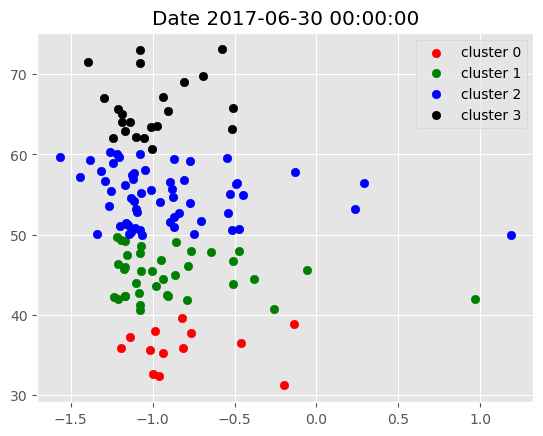

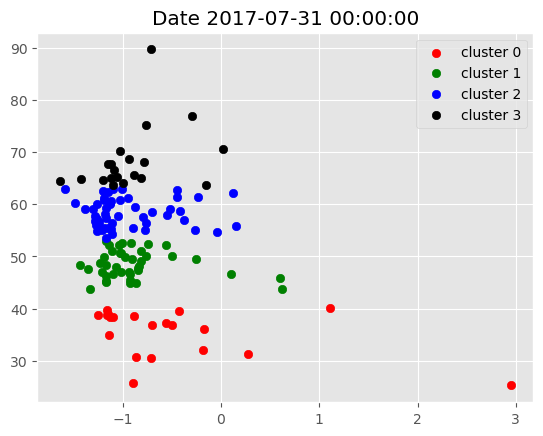

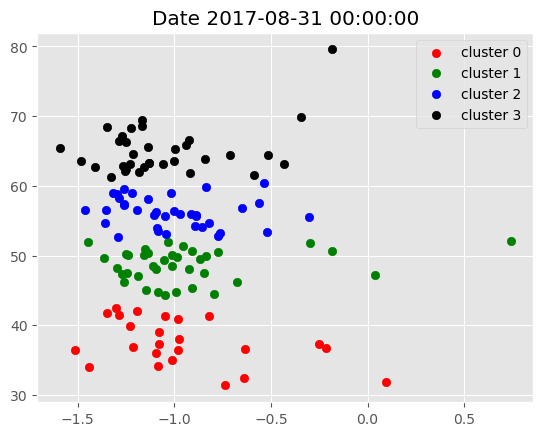

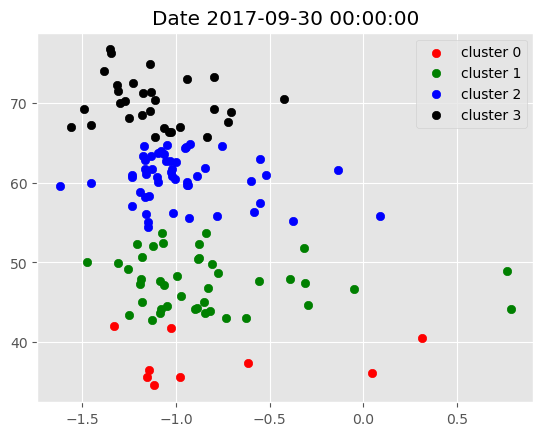

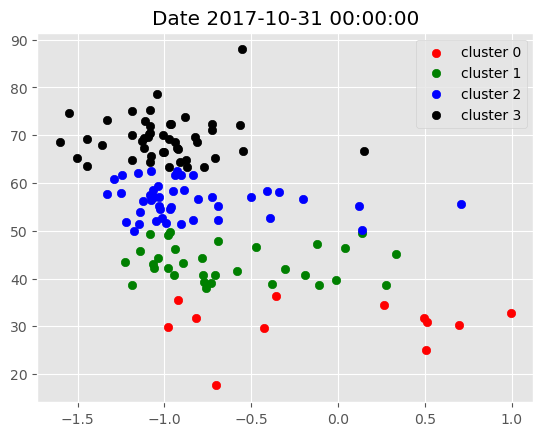

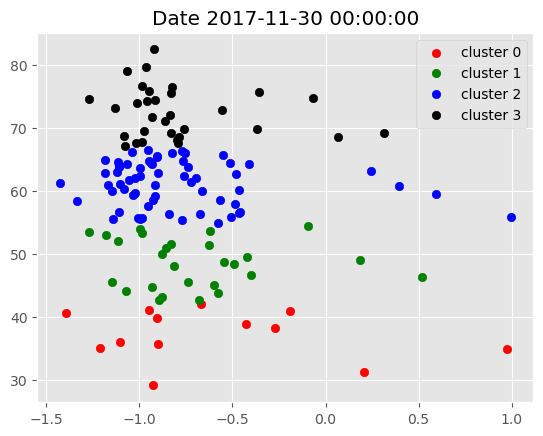

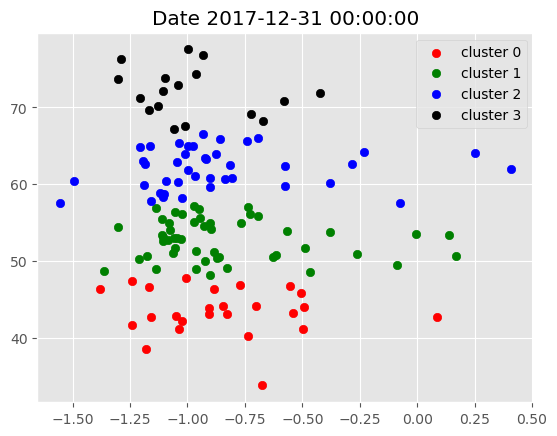

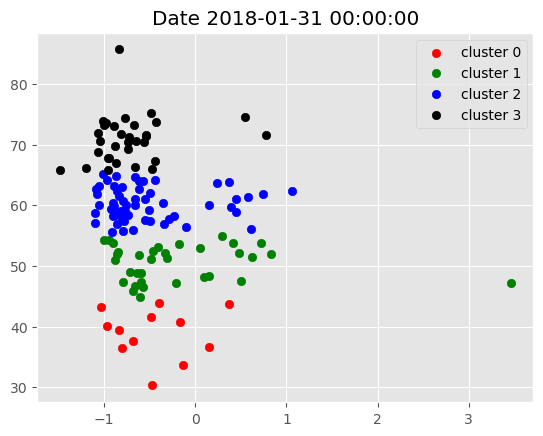

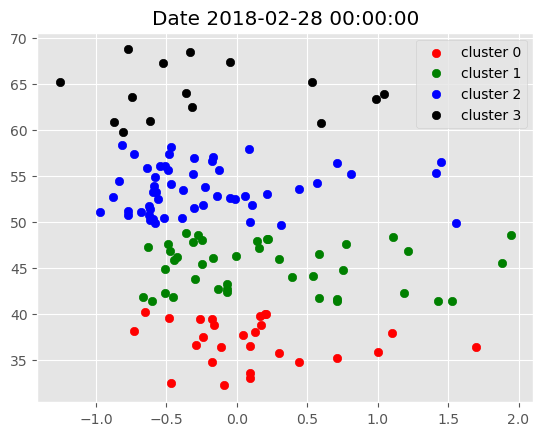

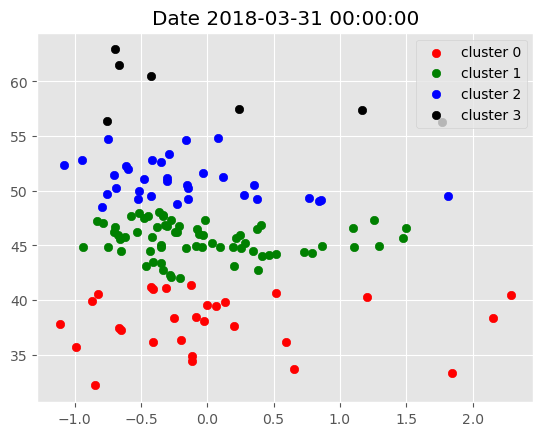

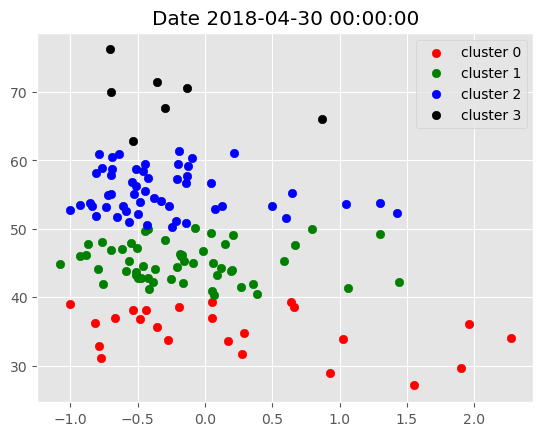

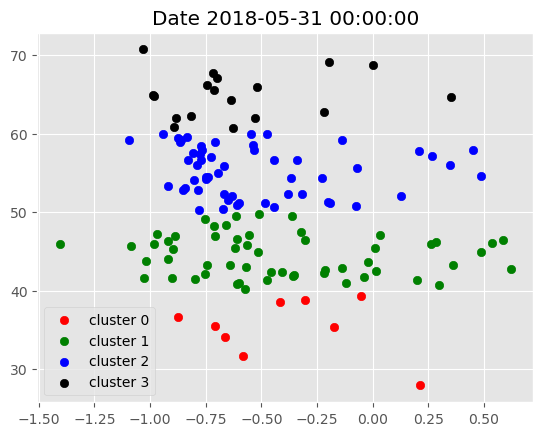

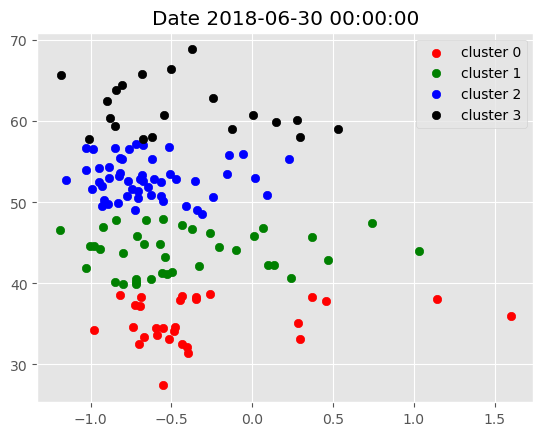

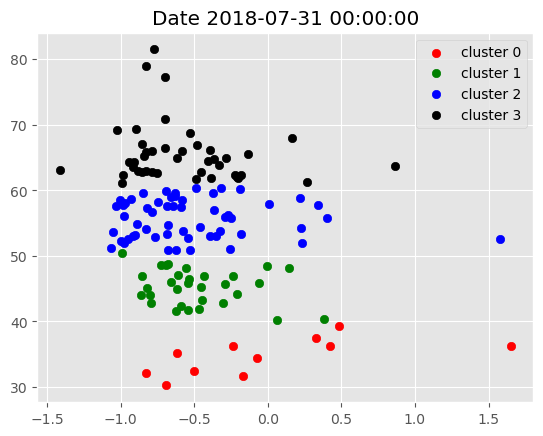

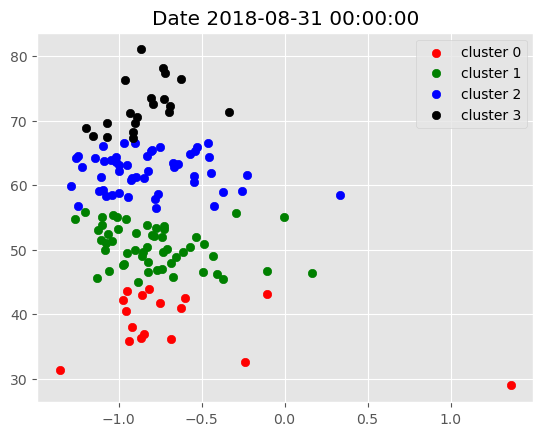

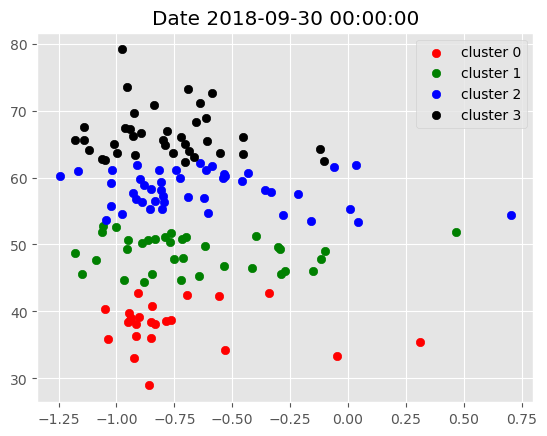

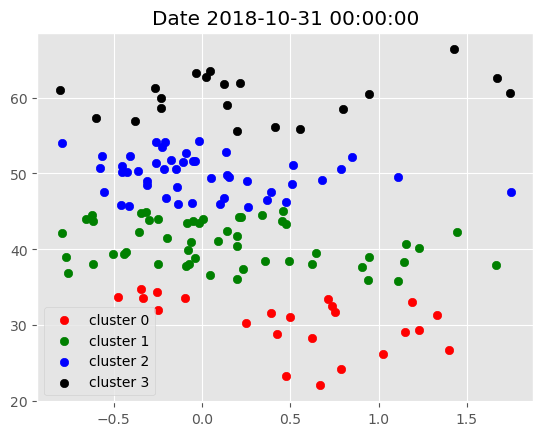

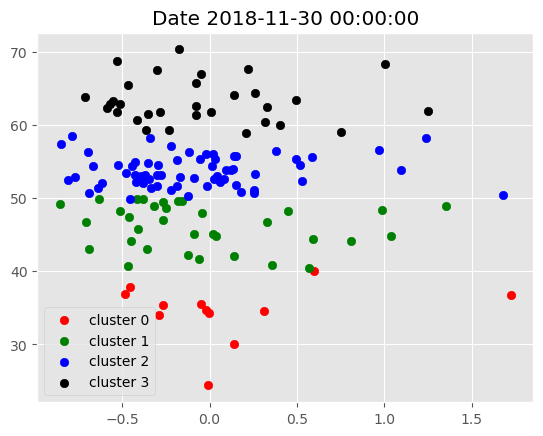

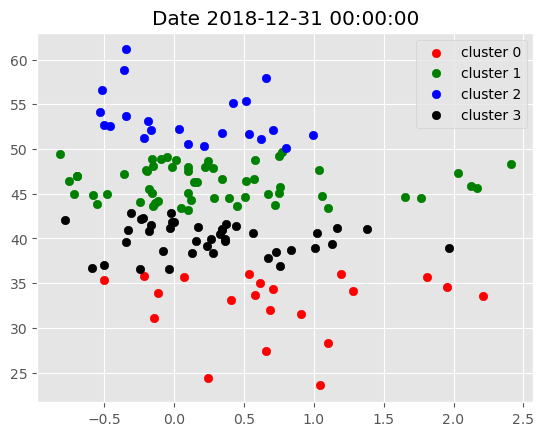

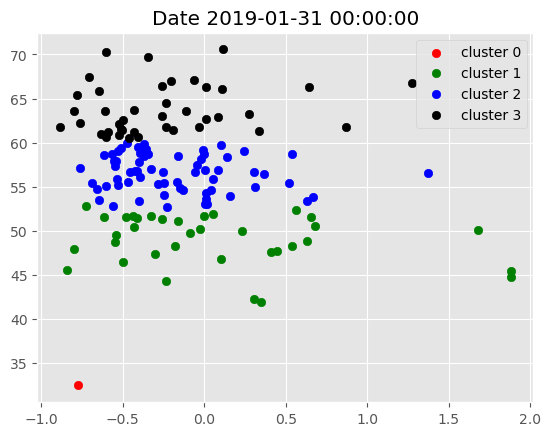

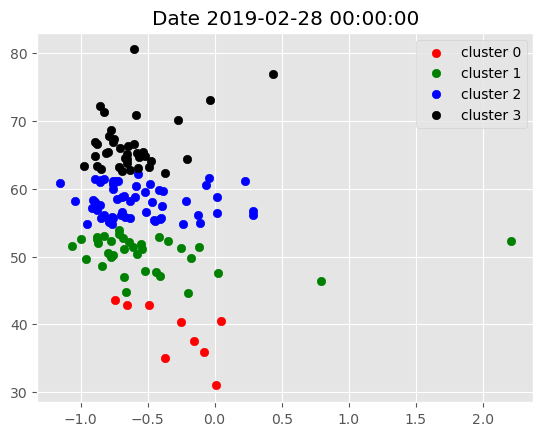

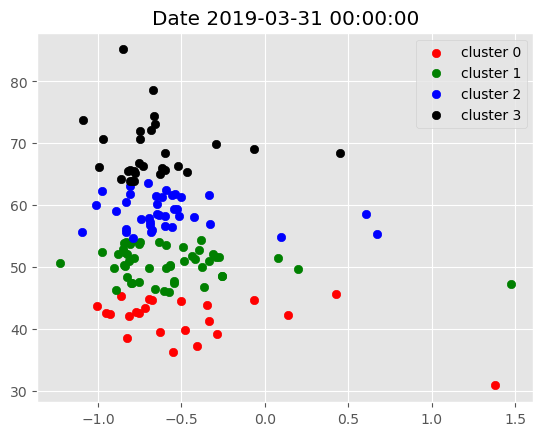

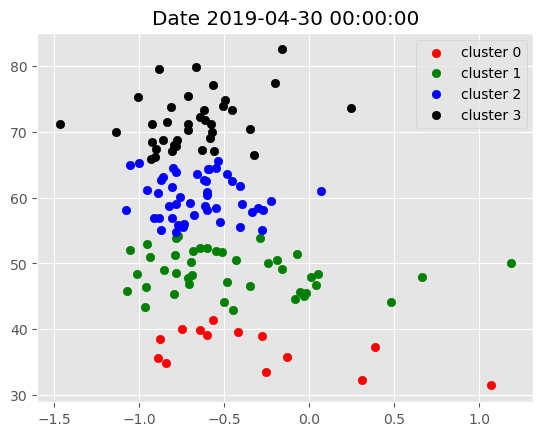

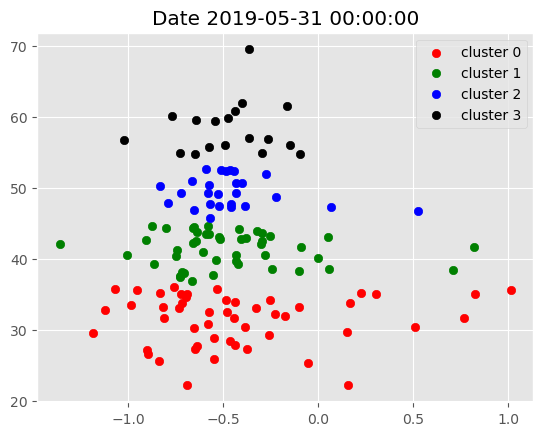

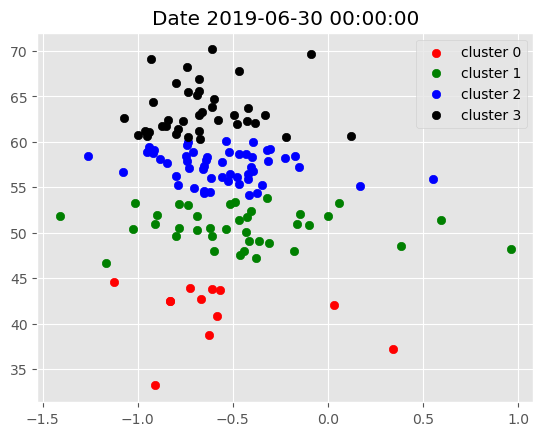

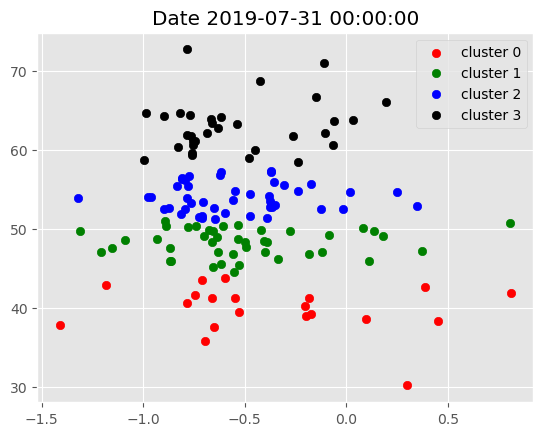

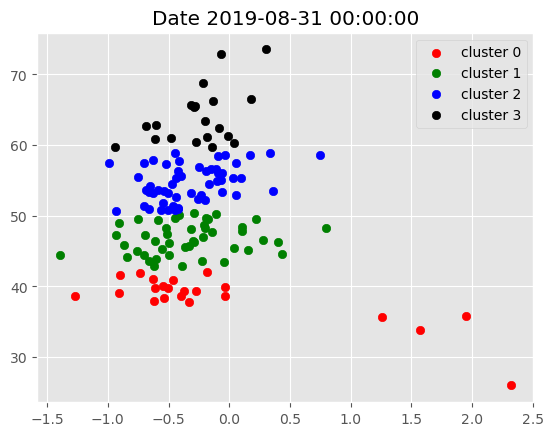

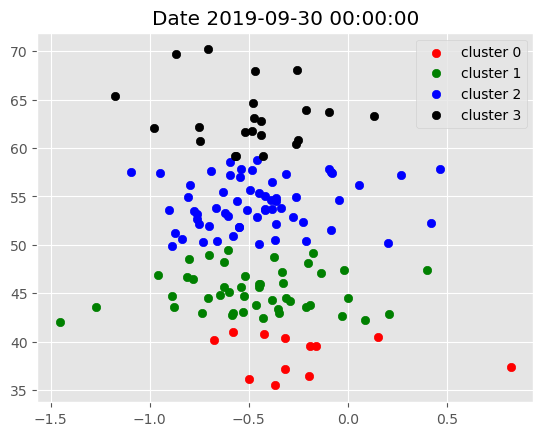

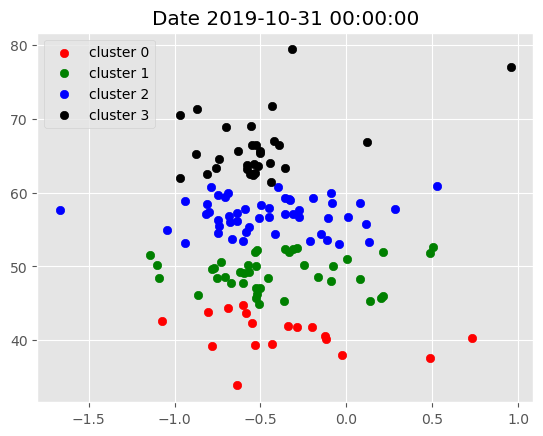

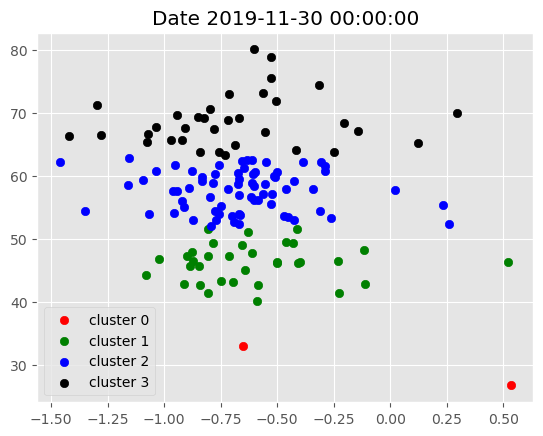

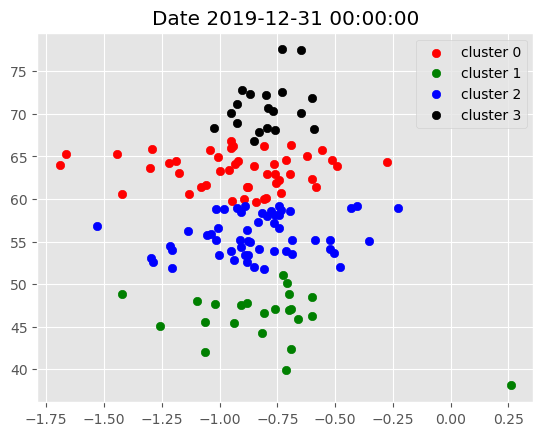

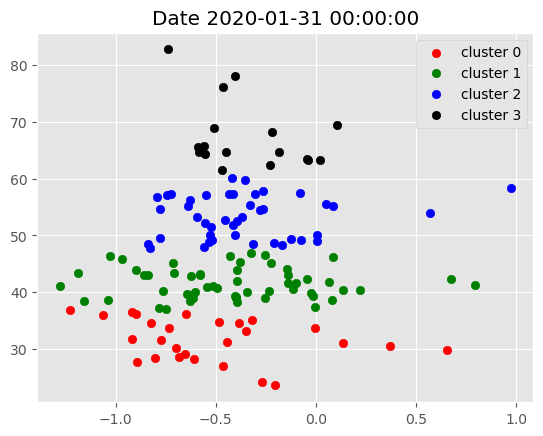

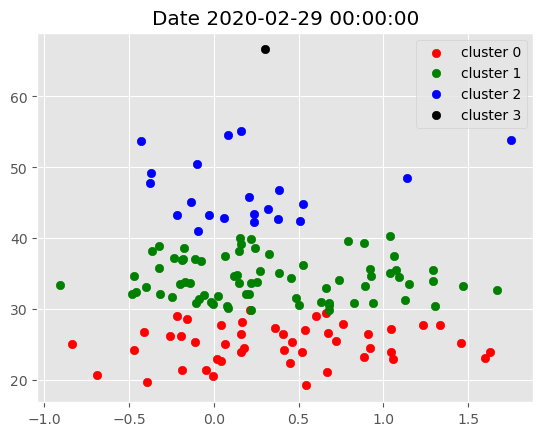

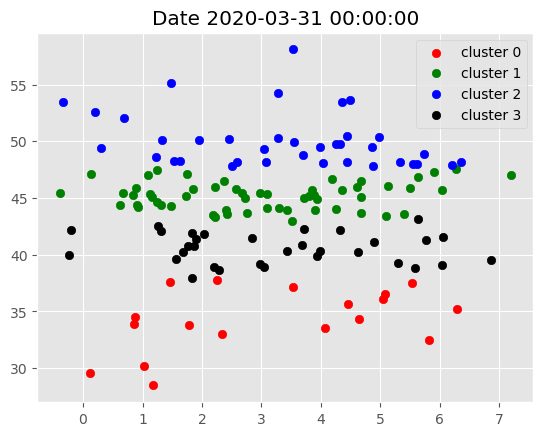

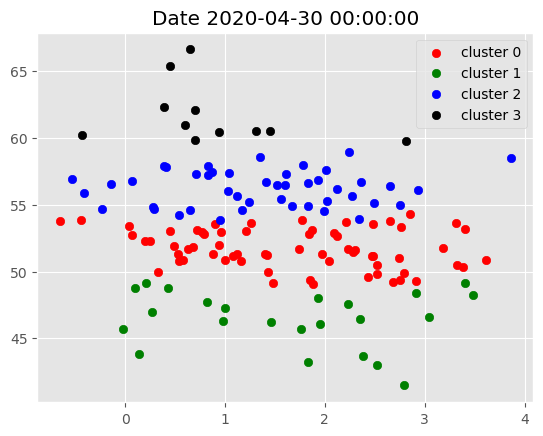

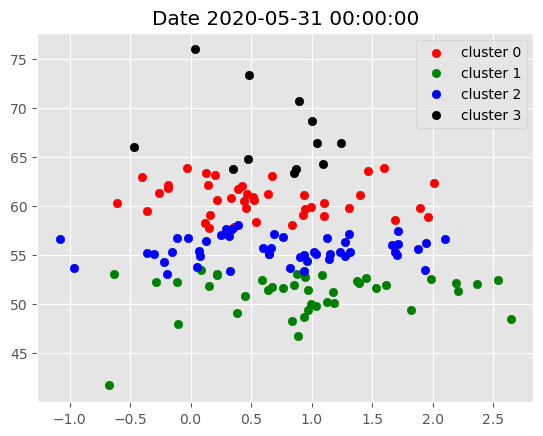

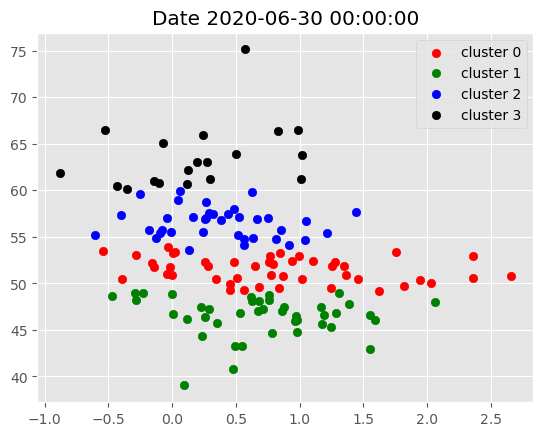

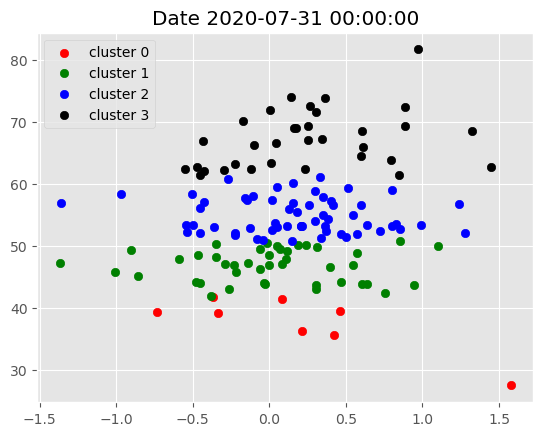

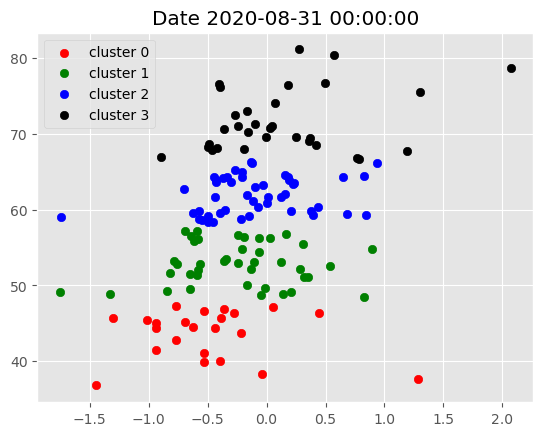

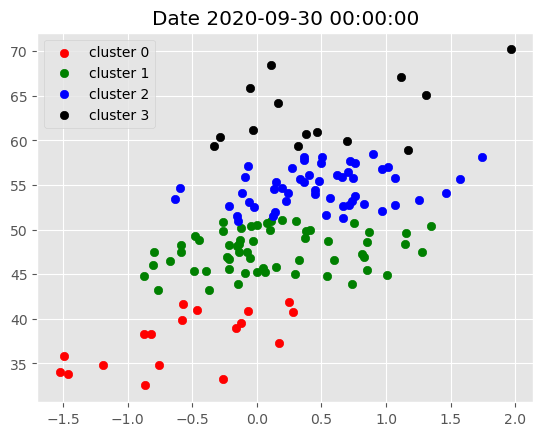

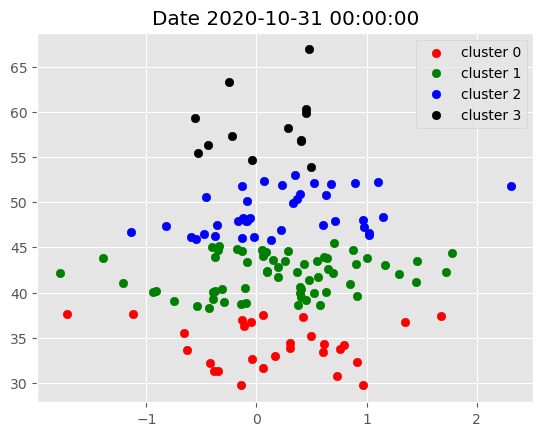

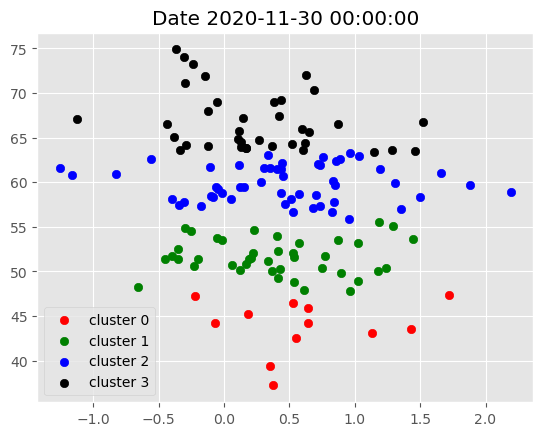

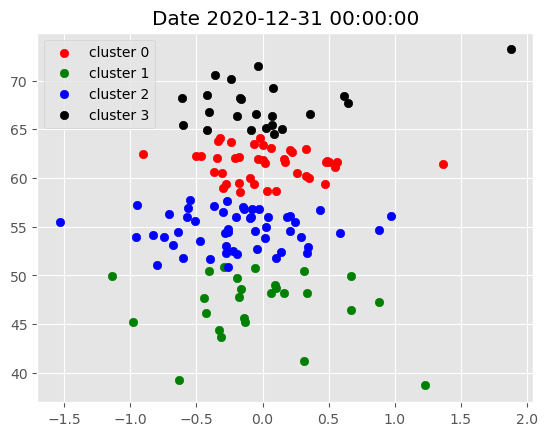

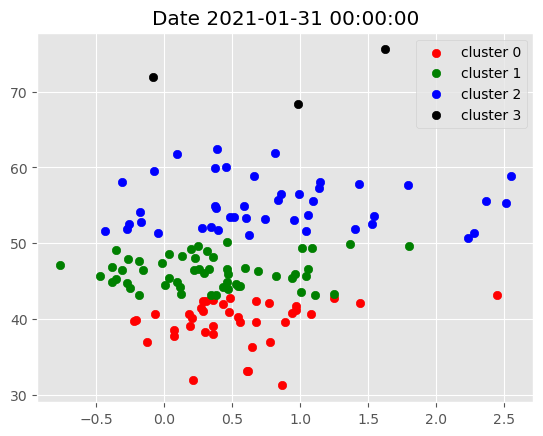

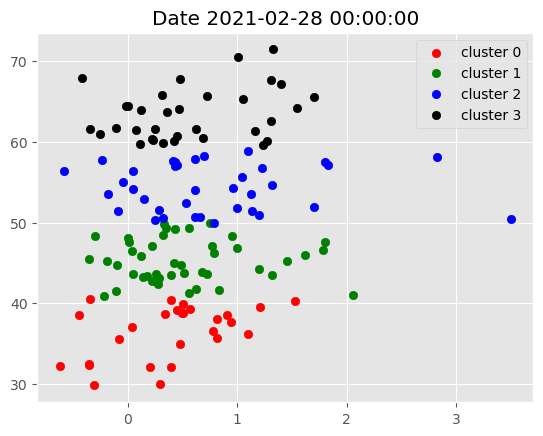

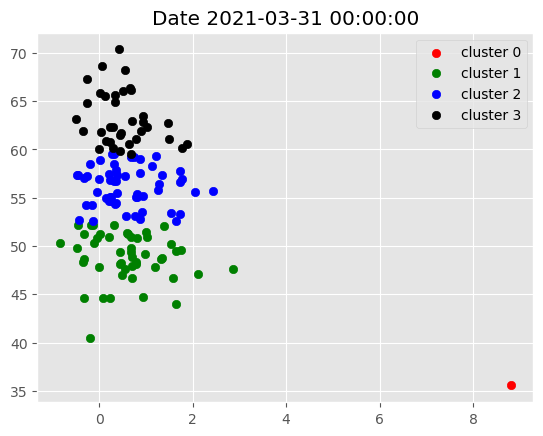

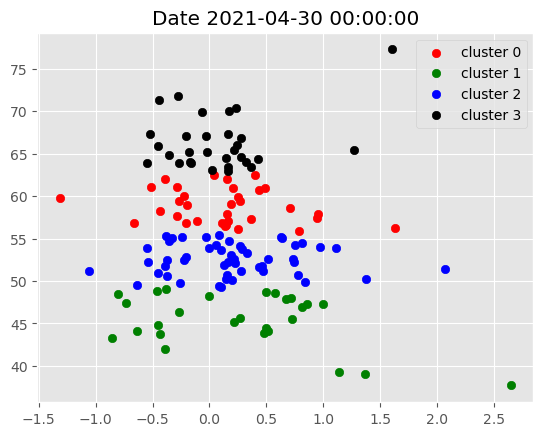

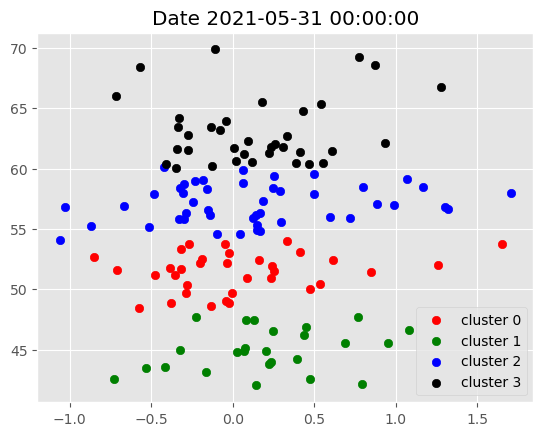

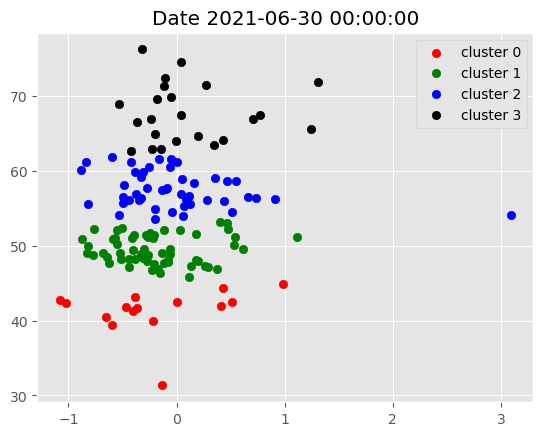

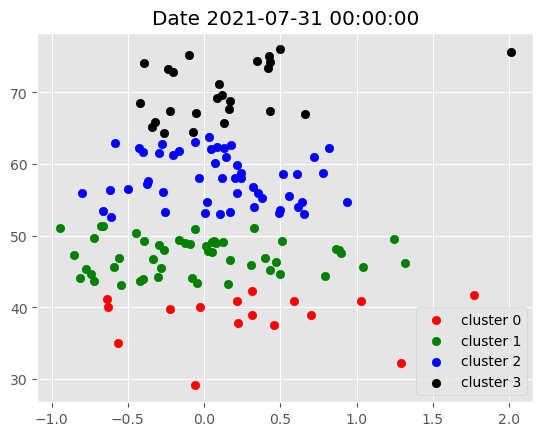

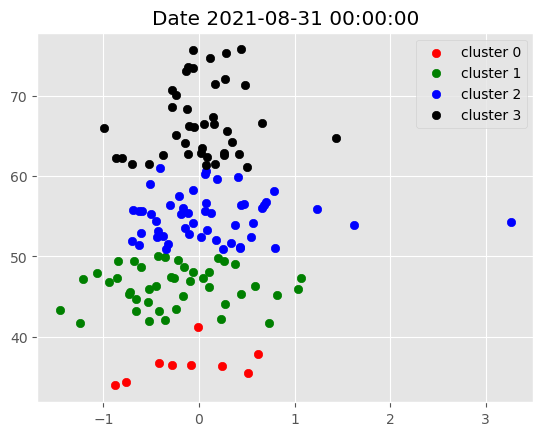

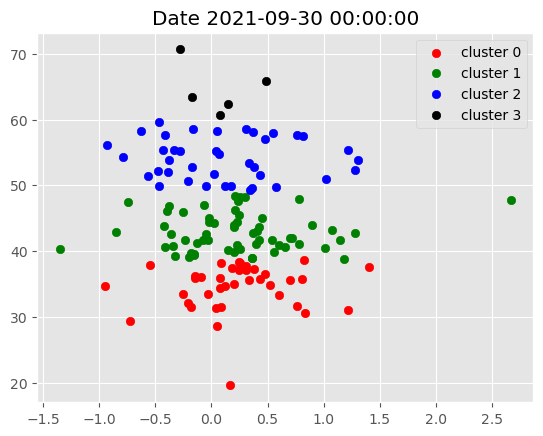

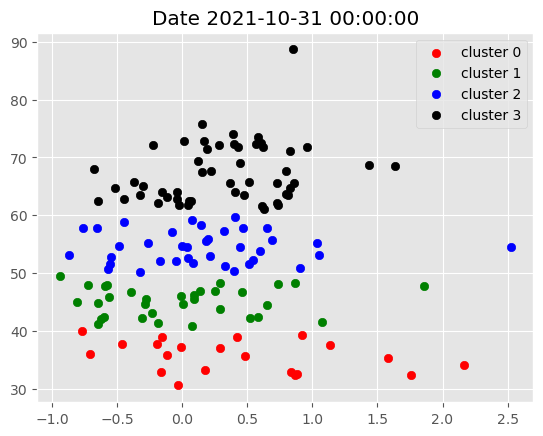

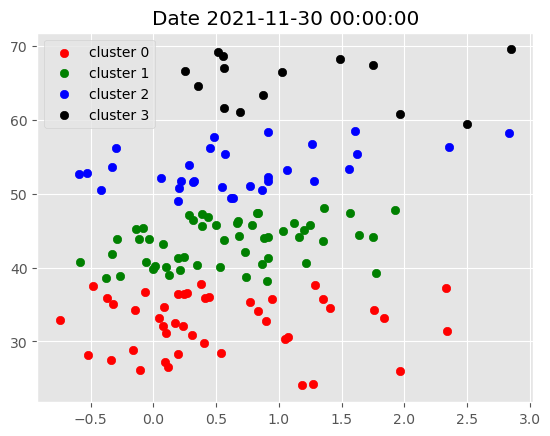

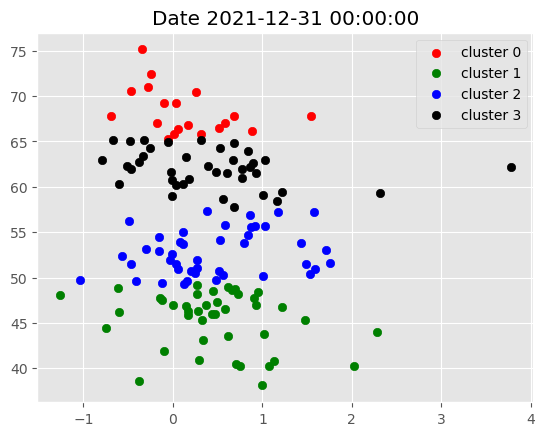

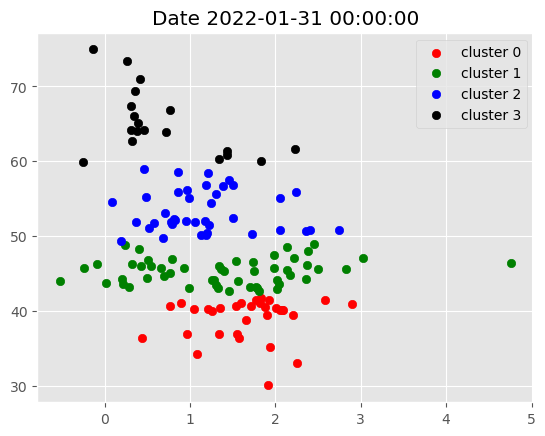

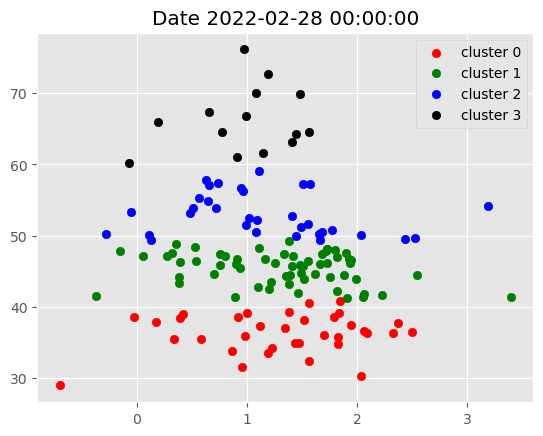

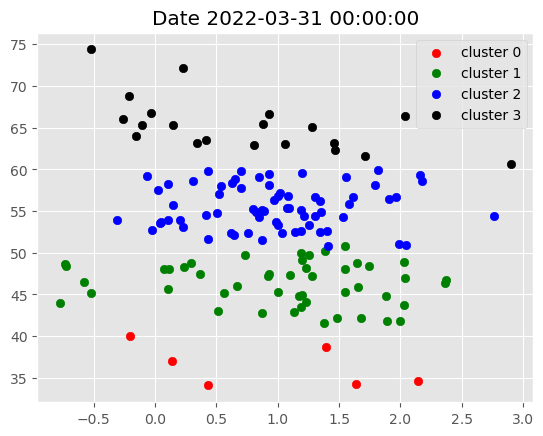

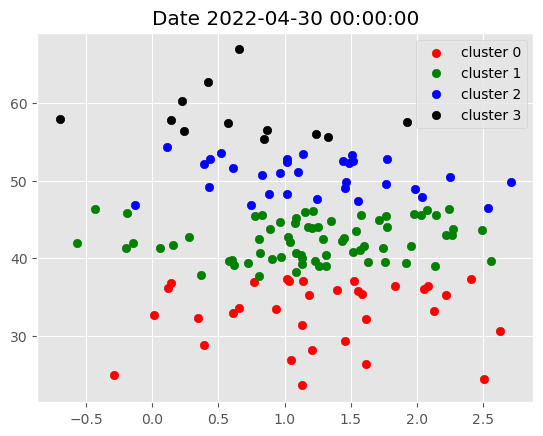

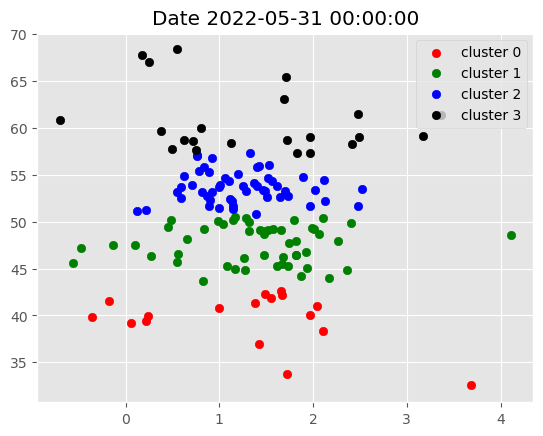

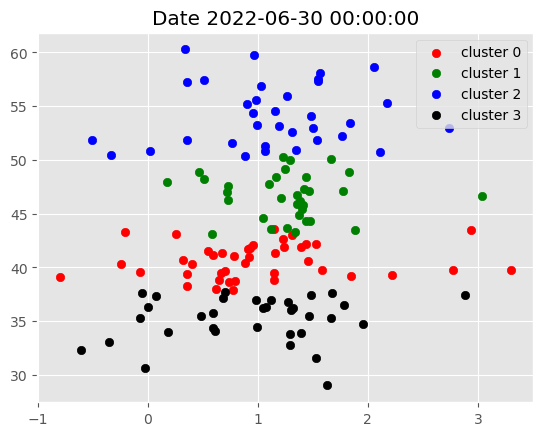

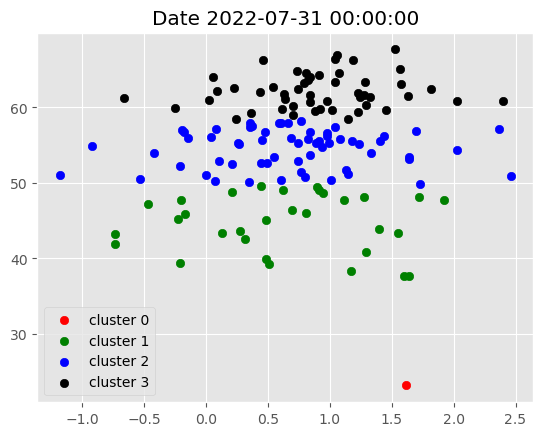

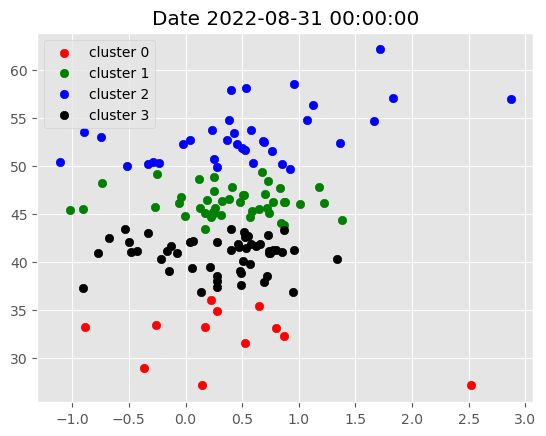

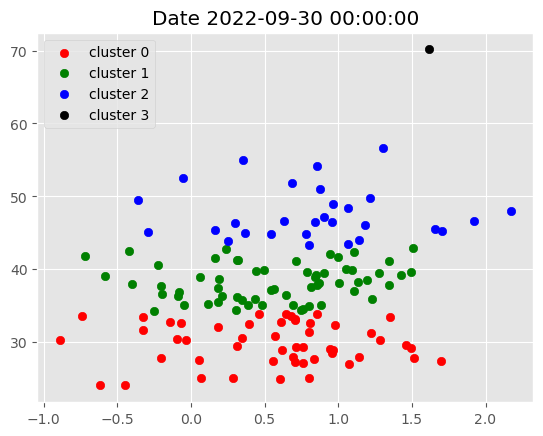

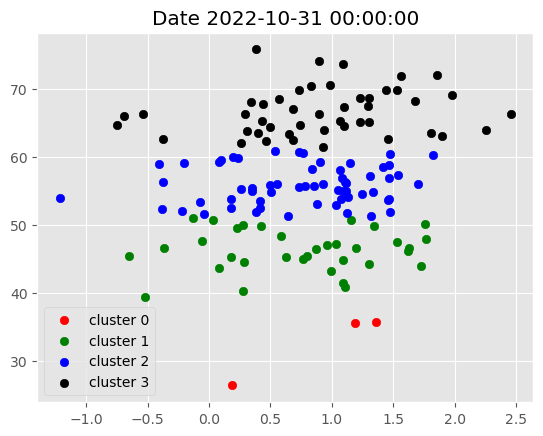

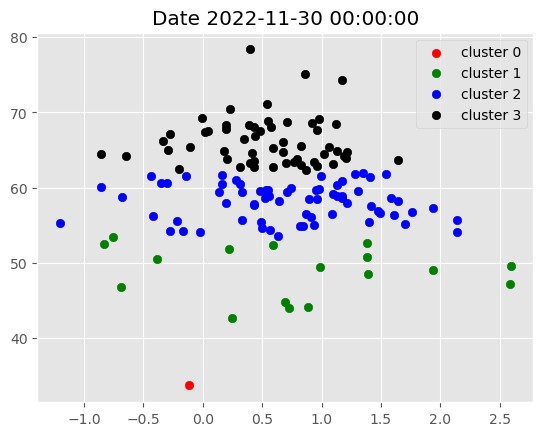

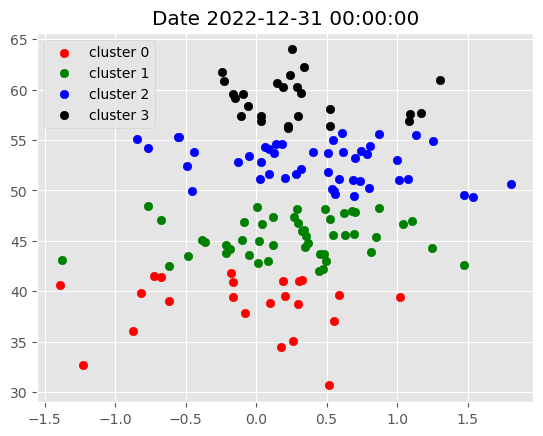

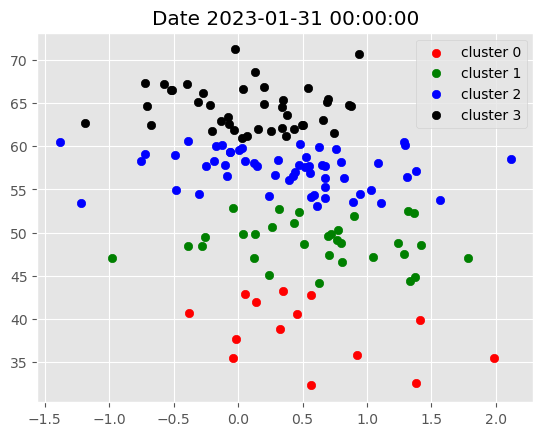

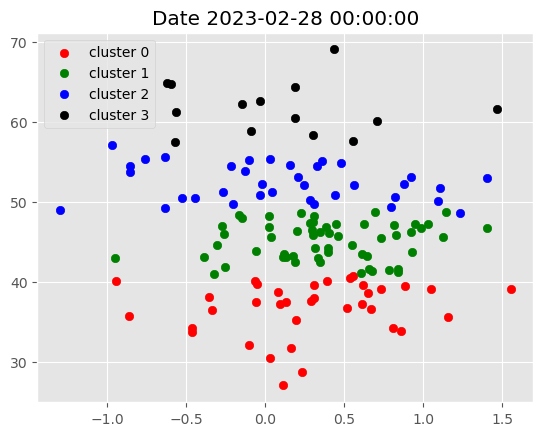

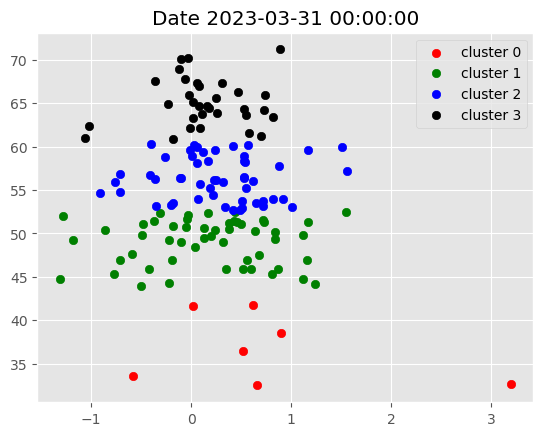

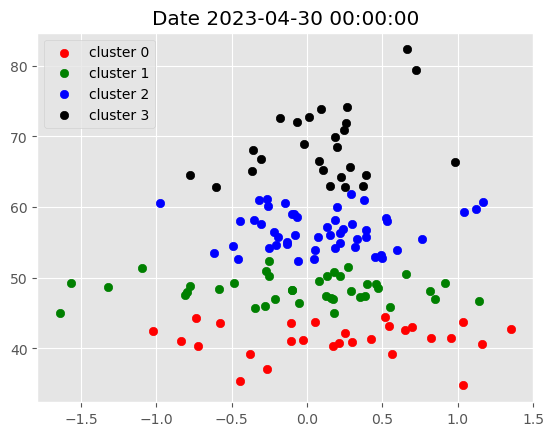

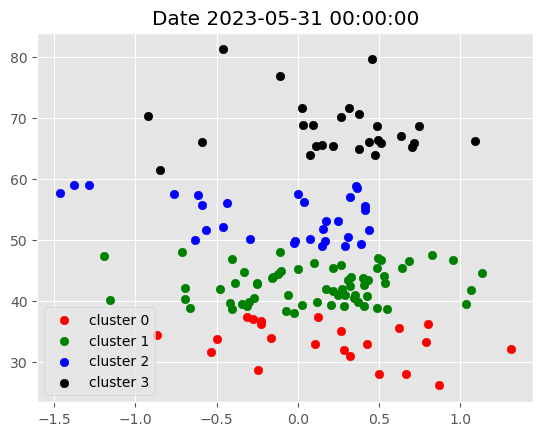

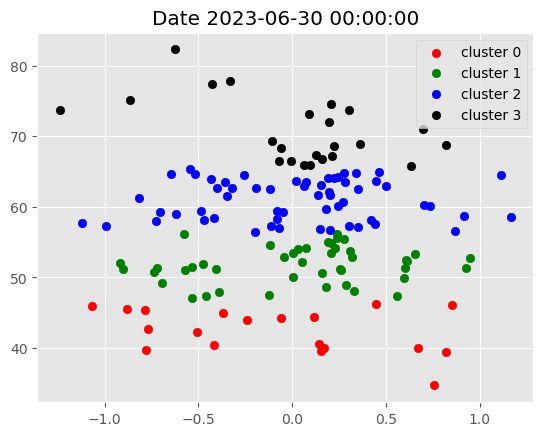

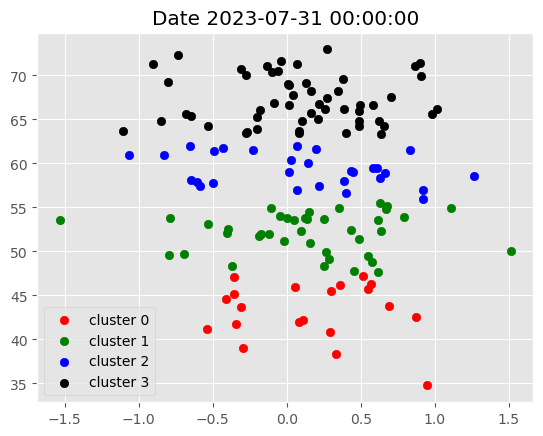

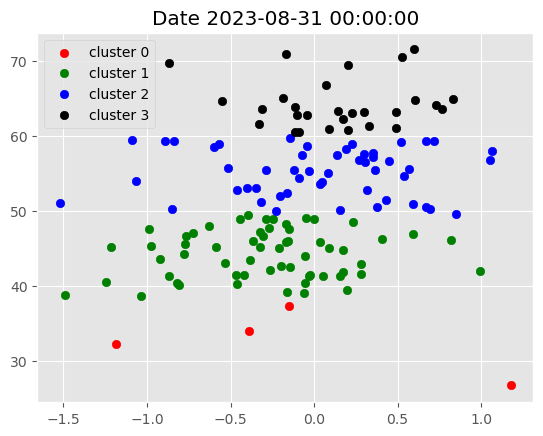

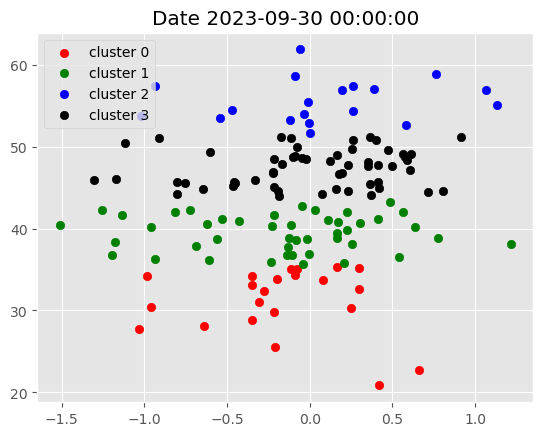

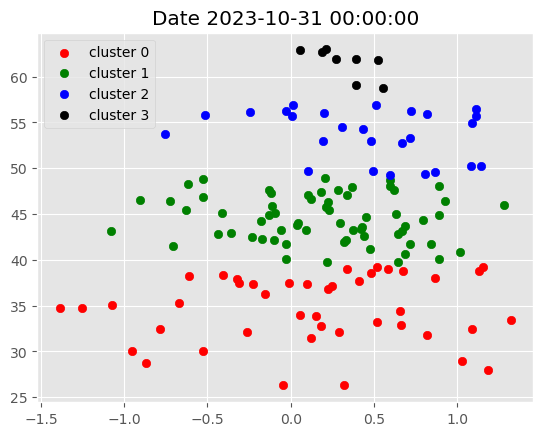

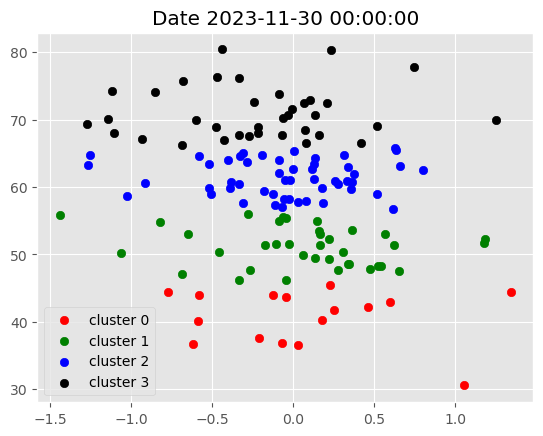

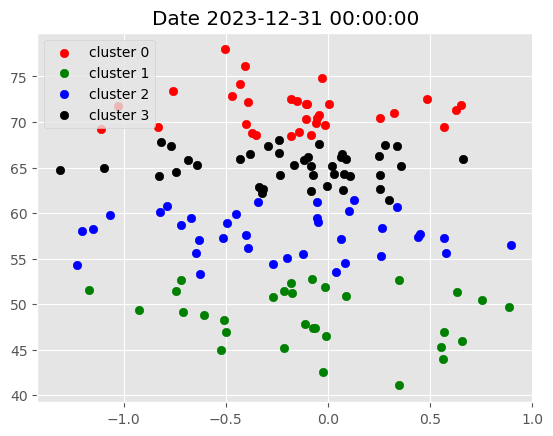

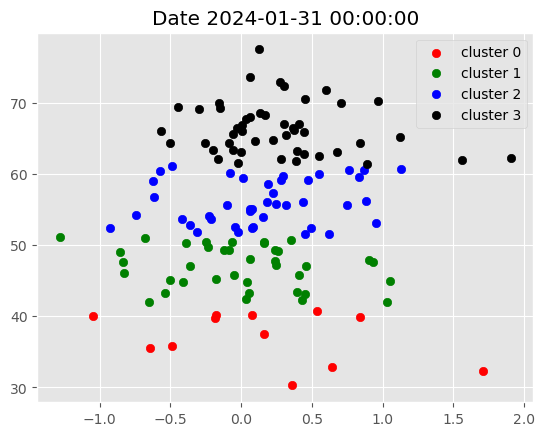

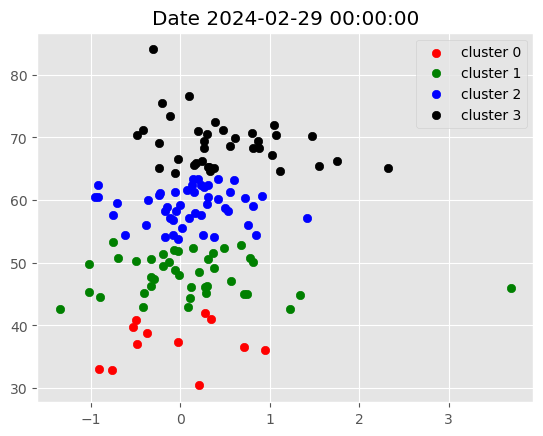

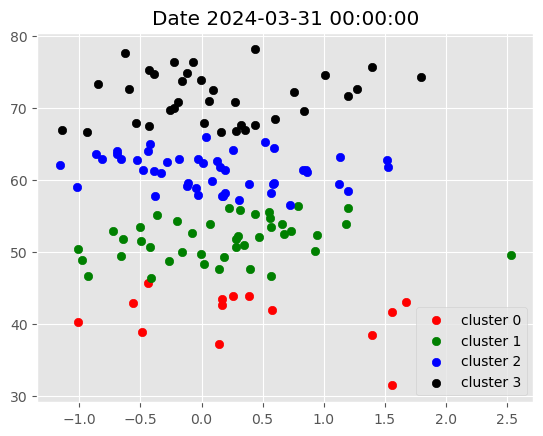

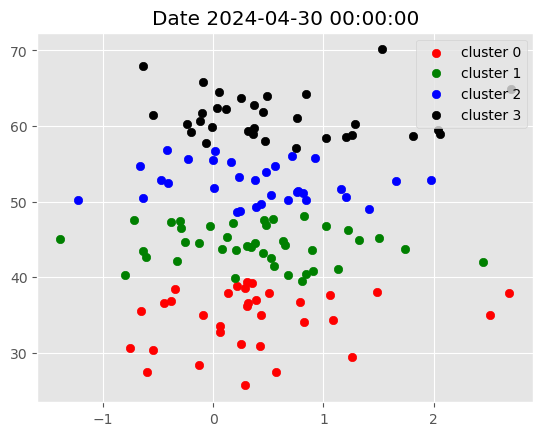

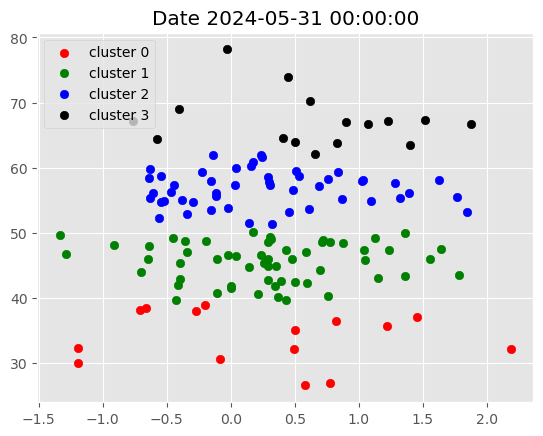

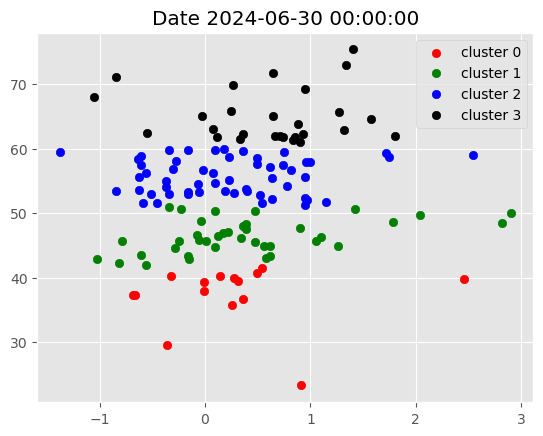

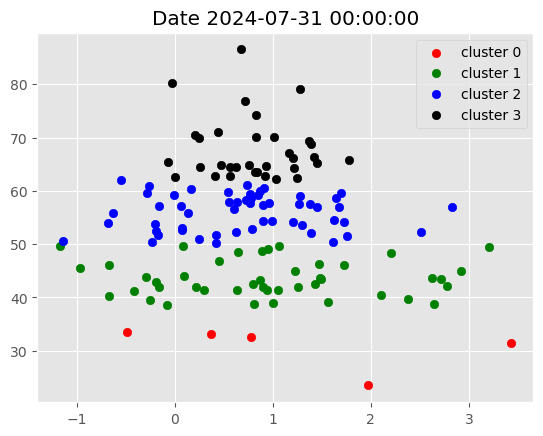

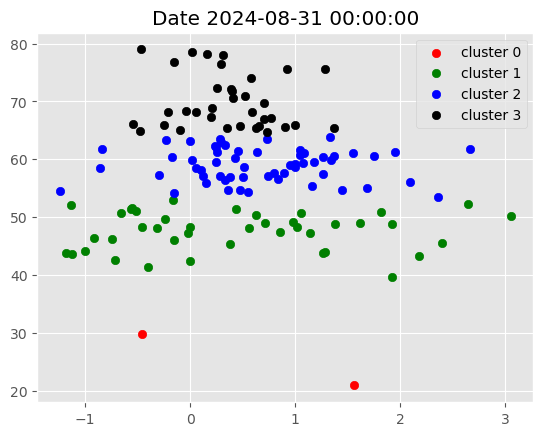

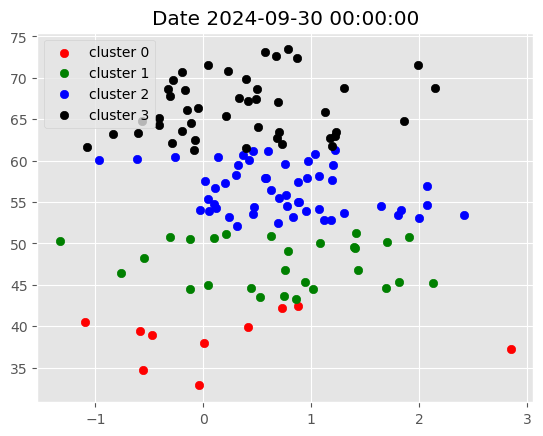

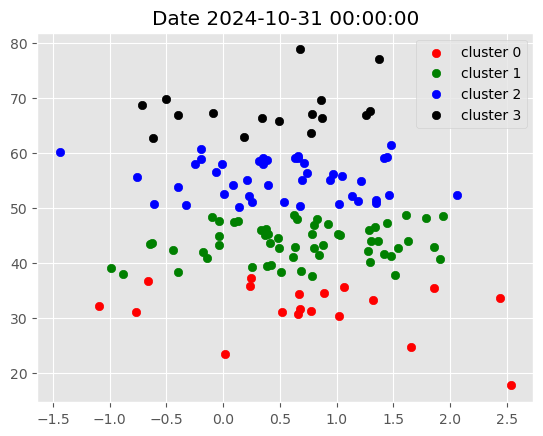

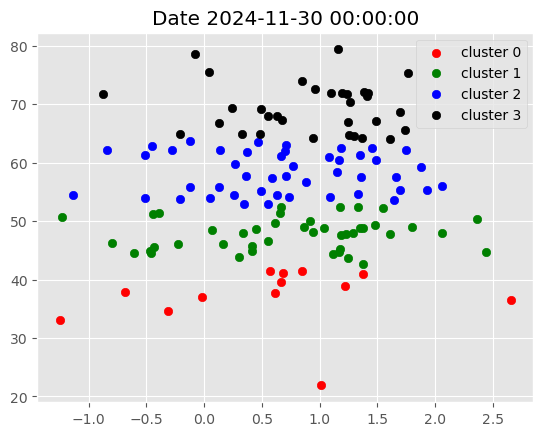

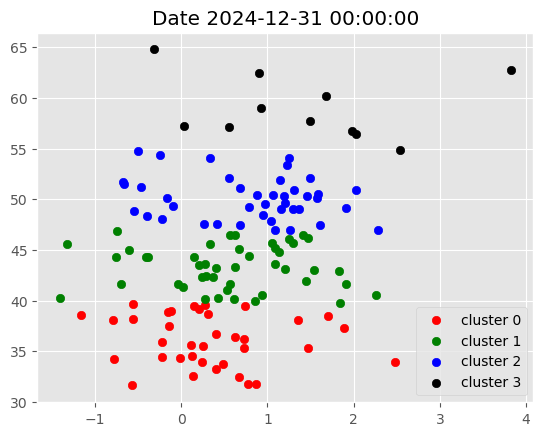

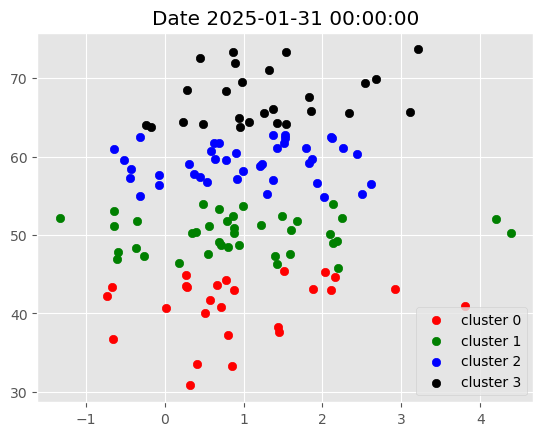

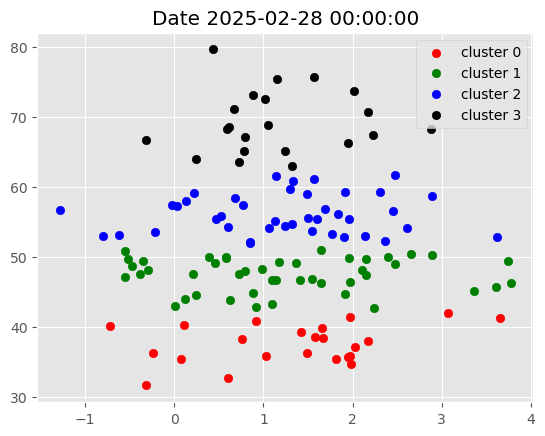

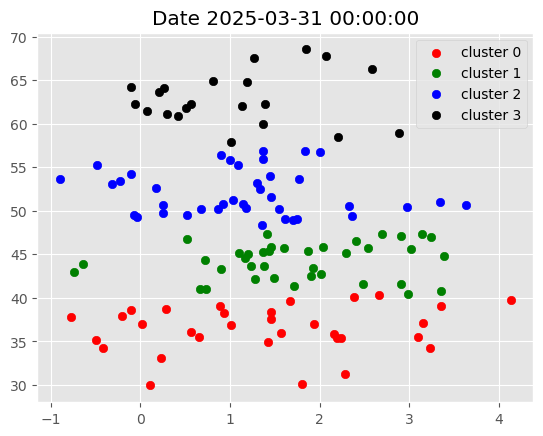

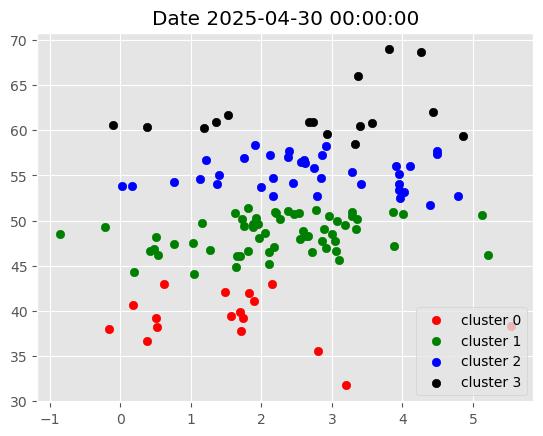

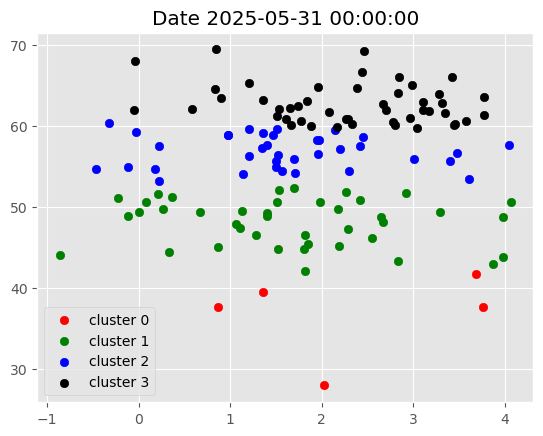

In [32]:
plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)
#higher rsi means more bullish momentum

In [33]:
#selecting stocks in cluster 3
filtered_df = data[data['cluster'] == 3].copy()
#removing ticker index
filtered_df = filtered_df.reset_index(level=1)
#converting last date of month to first date of next month
filtered_df.index = filtered_df.index+pd.DateOffset(1)
#re applying ticker index
filtered_df = filtered_df.reset_index().set_index(['date','ticker'])
#get dates
dates = filtered_df.index.get_level_values('date').unique().tolist()

In [34]:
#creating a dictionary with keys as dates and values as list of stocks we want to buy at the start of each month
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()
fixed_dates

{'2017-07-01': ['ABBV',
  'ABT',
  'AMGN',
  'AXP',
  'BA',
  'BLK',
  'C',
  'CSX',
  'DAL',
  'FDX',
  'GILD',
  'HUM',
  'ISRG',
  'JPM',
  'LUV',
  'MCD',
  'MDT',
  'MET',
  'NKE',
  'ORCL',
  'SCHW',
  'UNH'],
 '2017-08-01': ['AIG',
  'BA',
  'BKNG',
  'BRK-B',
  'C',
  'CAT',
  'CHTR',
  'CVX',
  'EA',
  'FCX',
  'GILD',
  'LMT',
  'META',
  'NEE',
  'NFLX',
  'NXPI',
  'PG',
  'UNH',
  'VZ',
  'WMT'],
 '2017-09-01': ['AAPL',
  'ABBV',
  'ABT',
  'ADBE',
  'AMGN',
  'BA',
  'BIIB',
  'BMY',
  'BRK-B',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CRM',
  'DD',
  'DLTR',
  'EA',
  'GILD',
  'GM',
  'HUM',
  'ISRG',
  'LMT',
  'MA',
  'MCD',
  'META',
  'MSFT',
  'NEE',
  'NXPI',
  'PFE',
  'PG',
  'PYPL',
  'TMO',
  'UNH',
  'V',
  'VRTX'],
 '2017-10-01': ['ABBV',
  'AMAT',
  'AXP',
  'BA',
  'BLK',
  'BMY',
  'C',
  'CAT',
  'COP',
  'CVX',
  'DLTR',
  'EOG',
  'F',
  'FDX',
  'GM',
  'HAL',
  'HD',
  'INTC',
  'MAR',
  'MET',
  'MU',
  'OXY',
  'SCHW',
  'SLB',
  'TXN',
  'UNP',
  'UP

In [35]:
#define portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
#we will assign weights to stocks on basis of sharpe(more sharpe gets more weight)
def optimize_weights(prices, lower_bound=0):
    #calculate expected returns
    returns = expected_returns.mean_historical_return(prices=prices,frequency=252)
    #calculate covariance
    cov = risk_models.sample_cov(prices=prices,frequency=252)
    #initializing the efficient frontier object
    ef = EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(lower_bound,.1),
                          solver='SCS')
    #calculating the weight of the stock
    weights = ef.max_sharpe()
    return ef.clean_weights()


In [36]:
#downloading fresh daily prices data only for short listed stocks
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers = stocks, start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1],auto_adjust=False)
new_df

[*********************100%***********************]  162 of 162 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2016-06-30   21.878294   42.336670   33.261837   98.156578   95.790001   
2016-07-01   21.944658   42.883743   33.456429   98.355850   95.320000   
2016-07-05   21.738697   42.343502   33.371830   97.991966   94.730003   
2016-07-06   21.862272   43.335083   34.547962   98.355850   95.180000   
2016-07-07   21.956104   43.376118   34.996418   97.645401   95.139999   
...                ...         ...         ...         ...         ...   
2025-05-06  198.509995  187.149994  133.059998  303.799988  382.980011   
2025-05-07  196.250000  188.089996  133.949997  306.089996  384.970001   
2025-05-08  197.490005  185.580002  134.000000  308.880005  383.989990   
2025-05-09  198.529999  184.600006  133.240005  307.899994  383.279999   
2025-05-12  210.789993  190.070007  131.990005  322.089996  395.940002   

Price                                                                  ...  \
Ticker             ADI         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-06-30   47.773151   76.258080   54.139999  42.347038   21.712769  ...   
2016-07-01   47.764732   76.988533   54.340000  42.331028   21.640308  ...   
2016-07-05   46.693531   77.453384   52.799999  41.001919   21.595015  ...   
2016-07-06   46.777889   77.544685   52.959999  41.041958   21.739948  ...   
2016-07-07   47.191177   77.611099   53.529999  41.490326   22.002638  ...   
...                ...         ...         ...        ...         ...  ...   
2025-05-06  195.600006  303.329987  278.640015  82.529999  153.029999  ...   
2025-05-07  199.860001  305.179993  283.359985  81.690002  155.809998  ...   
2025-05-08  202.779999  307.089996  289.619995  81.820000  156.000000  ...   
2025-05-09  207.509995  307.720001  287.480011  82.410004  155.610001  ...   
2025-05-12  223.149994  309.380005  293.200012  83.470001  167.990005  ...   

Price         Volume                                                  \
Ticker           VLO     VRTX        VZ       WBA     WDAY       WDC   
Date                                                                   
2016-06-30  10412900  1418500  22143300   5813200  1479000   8257505   
2016-07-01   5896200  1292700  16092300   4858300  1110000   6305153   
2016-07-05   7937300   870100  20703200   7629300  1813100   7578409   
2016-07-06  11096200  1705300  15761500  10537400  1127700   5647358   
2016-07-07  10444200  1254000  13574100   5560000  1062600  10361471   
...              ...      ...       ...       ...      ...       ...   
2025-05-06   3051600  8000700  12131500   8029800   905000   4952400   
2025-05-07   2500000  3996700  12826600  10475500  1117900   7564600   
2025-05-08   3289400  2940800  14967400  10057700  1804500   5320500   
2025-05-09   2167300  1642300  10878400   8466600  1325400   4960100   
2025-05-12   4135300  2095100  20148300  17405000  2062200   6957400   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2016-06-30  22538800  26140800  2580700  14073700  
2016-07-01  19013600  22916400  2821500   9946300  
2016-07-05  22213000  32245800  2405100  10744100  
2016-07-06  19024100  33188100  2133700  13144400  
2016-07-07  17946200  23378400  1999500  12240700  
...              ...       ...      ...       ...  
2025-05-06  18095100  10626000  3011500  16303400  
2025-05-07  14310300  11301300  3846700  12332200  
2025-05-08  19957500  14461100  3041300  19196500  
2025-05-09  11136900  13697800  3216400  10992100  
2025-05-12  20423200  26763300  4636800  14241700  

[2229 rows x 972 columns]

In [37]:
#printing the column names of the new dataframe
columns_level_1 = new_df.columns.get_level_values(0).unique()
print(columns_level_1)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [38]:
#calculating returns per day
returns_dataframe = np.log(new_df['Adj Close']).diff()
#initializing portfolio dataframe
portfolio_df = pd.DataFrame()
#showing returns
returns_dataframe

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,AMAT,...,VLO,VRTX,VZ,WBA,WDAY,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01,0.003029,0.012839,0.005833,0.002028,-0.004919,-0.000176,0.009533,0.003687,-0.000378,-0.003343,...,0.008396,0.019798,0.006960,-0.002525,-0.004429,-0.016857,-0.006359,-0.002880,0.012608,0.001066
2016-07-05,-0.009430,-0.012678,-0.002532,-0.003707,-0.006209,-0.022682,0.006020,-0.028749,-0.031901,-0.002095,...,-0.031404,-0.014118,0.005321,0.005523,-0.022996,-0.038386,-0.017589,0.004522,-0.029744,-0.008777
2016-07-06,0.005668,0.023148,0.034636,0.003707,0.004739,0.001805,0.001178,0.003026,0.000976,0.006689,...,-0.023960,0.035765,0.005257,-0.023870,-0.000689,0.016412,0.009477,0.009255,0.009272,0.011438
2016-07-07,0.004283,0.000946,0.012897,-0.007249,-0.000420,0.008796,0.000856,0.010705,0.010865,0.012011,...,-0.029617,0.004340,-0.015765,-0.012959,0.016258,0.047260,0.003210,-0.003936,-0.010845,-0.012083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06,-0.001912,-0.046561,0.003463,-0.012788,0.005026,-0.010780,-0.002075,-0.005119,-0.006281,-0.010272,...,-0.019803,-0.105674,0.013913,-0.000910,-0.002217,-0.016570,-0.005023,-0.007884,0.006486,0.013848
2025-05-07,-0.011450,0.005010,0.006666,0.007510,0.005183,0.021545,0.006080,0.016797,-0.010230,0.018003,...,-0.000427,-0.034382,-0.005906,0.005445,0.011197,0.000226,-0.004091,0.002837,0.007158,-0.000955
2025-05-08,0.006299,-0.013434,0.000373,0.009074,-0.002549,0.014505,0.006239,0.021852,0.001590,0.001219,...,0.040059,-0.012078,-0.006400,0.009905,0.029104,0.000000,0.001775,-0.014267,0.028940,0.013860


In [39]:
for start_date in fixed_dates.keys():
    try:
        #end date is the last day of the month
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        #selected stocks for the month
        cols = fixed_dates[start_date]
        #optimizing for 1 year previous data
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        #in case optimization fails due to lack of data
        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound = round(1/(len(optimization_df.columns)*2),3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            #if sufficient data is there to calculate weights
            success = True
        except:
            print(f'Max sharpie optimization failed for {start_date}, continuing with equal weights')
        if success == False:
            #we give equal weights to stocks when insufficient data
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                  index=optimization_df.columns.tolist(),
                                  columns=pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                          left_index=True,
                          right_index=True)\
                    .reset_index().set_index(['Date','Ticker']).unstack().stack()
        temp_df.index.names = ['date','ticker']
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        #portfolio dataframe
        portfolio_df = pd.concat([portfolio_df,temp_df], axis=0)
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Max sharpie optimization failed for 2018-04-01, continuing with equal weights
Max sharpie optimization failed for 2018-05-01, continuing with equal weights
Max sharpie optimization failed for 2020-03-01, continuing with equal weights
Max sharpie optimization failed for 2020-04-01, continuing with equal weights
Max sharpie optimization failed for 2021-02-01, continuing with equal weights
Max sharpie optimization failed for 2021-10-01, continuing with equal weights
Max sharpie optimization failed for 2022-07-01, continuing with equal weights
Max sharpie optimization failed for 2022-09-01, continuing with equal weights
Max sharpie optimization failed for 2022-10-01, continuing with equal weights
Max sharpie optimization failed for 2023-11-01, continuing with equal weights
'return'


,Strategy Return
date,
2017-07-03,0.001492
2017-07-05,0.008096
2017-07-06,-0.007778
2017-07-07,0.007532
2017-07-10,-0.000091
...,...
2025-05-06,-0.025267
2025-05-07,-0.002889
2025-05-08,-0.001649


In [40]:
#visualize portfolio returns and compare to SP500 returns
spy = yf.download(tickers='SPY',
                 start='2017-06-01',
                 end=dt.date.today(),auto_adjust=False)
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'},axis=1)
spy_ret.columns = spy_ret.columns.get_level_values(0)  # Extract single-level column names
portfolio_df = portfolio_df.merge(spy_ret,
                                 left_index=True,
                                 right_index=True)
portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-07-03,0.001492,0.001694
2017-07-05,0.008096,0.002309
2017-07-06,-0.007778,-0.009187
2017-07-07,0.007532,0.006464
2017-07-10,-0.000091,0.001073
...,...,...
2025-05-06,-0.025267,-0.008393
2025-05-07,-0.002889,0.004197
2025-05-08,-0.001649,0.006944
2025-05-09,-0.006177,-0.001275


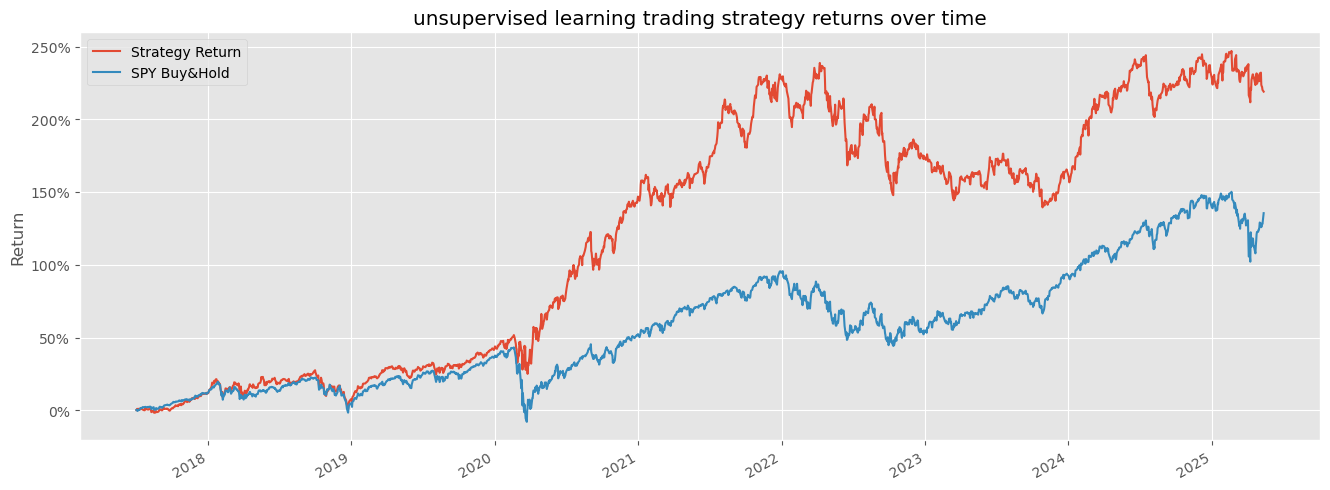

In [41]:
#plotting graph between our portfolio strategy returns and returns we get if we put equal weight in all SP500 stocks
import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2025-05-12'].plot(figsize=(16,6))
plt.title('unsupervised learning trading strategy returns over time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()